In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import numpy as np
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

# add reproducibility stuff
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


d:\Antonio\python\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available


In [2]:
def fastfood_vars(DD, device=0):
    """
    Returns parameters for fast food transform
    :param DD: desired dimension
    :return:
    """
    ll = int(np.ceil(np.log(DD) / np.log(2)))
    LL = 2**ll

    # Binary scaling matrix where $B_{i,i} \in \{\pm 1 \}$ drawn iid
    BB = torch.FloatTensor(LL).uniform_(0, 2).type(torch.LongTensor)
    BB = (BB * 2 - 1).type(torch.FloatTensor).to(device)
    BB.requires_grad = False

    # Random permutation matrix
    Pi = torch.LongTensor(np.random.permutation(LL)).to(device)
    Pi.requires_grad = False

    # Gaussian scaling matrix, whose elements $G_{i,i} \sim \mathcal{N}(0, 1)$
    GG = (
        torch.FloatTensor(
            LL,
        )
        .normal_()
        .to(device)
    )
    GG.requires_grad = False

    divisor = torch.sqrt(LL * torch.sum(torch.pow(GG, 2)))

    return [BB, Pi, GG, divisor, LL]


In [ ]:
def fast_walsh_hadamard_torched(x, axis=0, normalize=False):
    """
    Performs fast Walsh Hadamard transform
    :param x:
    :param axis:
    :param normalize:
    :return:
    """
    orig_shape = x.size()
    assert axis >= 0 and axis < len(
        orig_shape
    ), "For a vector of shape %s, axis must be in [0, %d] but it is %d" % (
        orig_shape,
        len(orig_shape) - 1,
        axis,
    )
    h_dim = orig_shape[axis]
    h_dim_exp = int(round(np.log(h_dim) / np.log(2)))
    assert h_dim == 2**h_dim_exp, (
        "hadamard can only be computed over axis with size that is a power of two, but"
        " chosen axis %d has size %d" % (axis, h_dim)
    )

    working_shape_pre = [int(np.prod(orig_shape[:axis]))]  # prod of empty array is 1 :)
    working_shape_post = [
        int(np.prod(orig_shape[axis + 1 :]))
    ]  # prod of empty array is 1 :)
    working_shape_mid = [2] * h_dim_exp
    working_shape = working_shape_pre + working_shape_mid + working_shape_post

    ret = x.view(working_shape)

    for ii in range(h_dim_exp):
        dim = ii + 1
        arrs = torch.chunk(ret, 2, dim=dim)
        assert len(arrs) == 2
        ret = torch.cat((arrs[0] + arrs[1], arrs[0] - arrs[1]), axis=dim)

    if normalize:
        ret = ret / torch.sqrt(float(h_dim))

    ret = ret.view(orig_shape)

    return ret


In [ ]:
def fastfood_torched(x, DD, param_list=None, device=0):
    """
    Fastfood transform
    :param x: array of dd dimension
    :param DD: desired dimension
    :return:
    """
    dd = x.size(0)

    if not param_list:

        BB, Pi, GG, divisor, LL = fastfood_vars(DD, device=device)

    else:

        BB, Pi, GG, divisor, LL = param_list

    # Padd x if needed
    dd_pad = F.pad(x, pad=(0, LL - dd), value=0, mode="constant")

    # From left to right HGPiH(BX), where H is Walsh-Hadamard matrix
    mul_1 = torch.mul(BB, dd_pad)
    # HGPi(HBX)
    mul_2 = fast_walsh_hadamard_torched(mul_1, 0, normalize=False)

    # HG(PiHBX)
    mul_3 = mul_2[Pi]

    # H(GPiHBX)
    mul_4 = torch.mul(mul_3, GG)

    # (HGPiHBX)
    mul_5 = fast_walsh_hadamard_torched(mul_4, 0, normalize=False)

    ret = torch.div(mul_5[:DD], divisor * np.sqrt(float(DD) / LL))

    return ret


In [2]:
class FastfoodWrapper(nn.Module):
    def __init__(self, module, intrinsic_dimension, device):
        """
        Wrapper to estimate the intrinsic dimensionality of the
        objective landscape for a specific task given a specific model using FastFood transform
        :param module: pytorch nn.Module
        :param intrinsic_dimension: dimensionality within which we search for solution
        :param device: cuda device id
        """
        super(FastfoodWrapper, self).__init__()

        # Hide this from inspection by get_parameters()
        self.m = [module]

        self.name_base_localname = []

        # Stores the initial value: \theta_{0}^{D}
        self.initial_value = dict()

        # Fastfood parameters
        self.fastfood_params = {}

        # Parameter vector that is updated
        # Initialised with zeros as per text: \theta^{d}
        V = nn.Parameter(torch.zeros((intrinsic_dimension)).to(device))
        self.register_parameter("V", V)
        v_size = (intrinsic_dimension,)

        # Iterate over layers in the module
        for name, param in module.named_parameters():
            # If param requires grad update
            if param.requires_grad:

                # Saves the initial values of the initialised parameters from param.data and sets them to no grad.
                # (initial values are the 'origin' of the search)
                self.initial_value[name] = v0 = (
                    param.clone().detach().requires_grad_(False).to(device)
                )

                # Generate fastfood parameters
                DD = np.prod(v0.size())
                self.fastfood_params[name] = fastfood_vars(DD, device)

                base, localname = module, name
                while "." in localname:
                    prefix, localname = localname.split(".", 1)
                    base = base.__getattr__(prefix)
                self.name_base_localname.append((name, base, localname))

        for name, base, localname in self.name_base_localname:
            delattr(base, localname)

    def forward(self, x):
        # Iterate over layers
        for name, base, localname in self.name_base_localname:

            init_shape = self.initial_value[name].size()
            DD = np.prod(init_shape)

            # Fastfood transform te replace dence P
            ray = fastfood_torched(self.V, DD, self.fastfood_params[name]).view(
                init_shape
            )

            param = self.initial_value[name] + ray

            setattr(base, localname, param)

        # Pass through the model, by getting hte module from a list self.m
        module = self.m[0]
        x = module(x)
        return x


In [2]:
class DenseWrap(nn.Module):
    def __init__(self, module, intrinsic_dimension, device):
        """
        Wrapper to estimate the intrinsic dimensionality of the
        objective landscape for a specific task given a specific model
        :param module: pytorch nn.Module
        :param intrinsic_dimension: dimensionality within which we search for solution
        :param device: cuda device id
        """
        super(DenseWrap, self).__init__()

        # Hide this from inspection by get_parameters()
        self.m = [module]

        self.name_base_localname = []

        # Stores the initial value: \theta_{0}^{D}
        self.initial_value = dict()

        # Stores the randomly generated projection matrix P
        self.random_matrix = dict()

        # Parameter vector that is updated, initialised with zeros as per text: \theta^{d}
        V = nn.Parameter(torch.zeros((intrinsic_dimension, 1)).to(device))
        self.register_parameter("V", V)
        v_size = (intrinsic_dimension,)

        # Iterates over layers in the Neural Network
        for name, param in module.named_parameters():
            # If the parameter requires gradient update
            if param.requires_grad:

                # Saves the initial values of the initialised parameters from param.data and sets them to no grad.
                # (initial values are the 'origin' of the search)
                self.initial_value[name] = v0 = (
                    param.clone().detach().requires_grad_(False).to(device)
                )

                # If v0.size() is [4, 3], then below operation makes it [4, 3, v_size]
                matrix_size = v0.size() + v_size

                # Generates random projection matrices P, sets them to no grad
                self.random_matrix[name] = (
                    torch.randn(matrix_size, requires_grad=False).to(device)
                    / intrinsic_dimension**0.5
                )

                # NOTE!: lines below are not clear!
                base, localname = module, name
                while "." in localname:
                    prefix, localname = localname.split(".", 1)
                    base = base.__getattr__(prefix)
                self.name_base_localname.append((name, base, localname))

        for name, base, localname in self.name_base_localname:
            delattr(base, localname)

    def forward(self, x):
        # Iterate over the layers
        for name, base, localname in self.name_base_localname:

            # Product between matrix P and \theta^{d}
            ray = torch.matmul(self.random_matrix[name], self.V)

            # Add the \theta_{0}^{D} to P \dot \theta^{d}
            param = self.initial_value[name] + torch.squeeze(ray, -1)

            setattr(base, localname, param)

        # Pass through the model, by getting the module from a list self.m
        module = self.m[0]
        x = module(x)
        return x


In [8]:
# implementig the code from the paper https://arxiv.org/abs/1804.08838 in pytorch
class Classifier(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_dim, n_classes)
        self.maxpool = nn.AdaptiveMaxPool2d(1)

    def forward(self, x):
        x = self.maxpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x


def get_resnet(encoder_name, num_classes, pretrained=False):
    assert encoder_name in [
        "resnet18",
        "resnet50",
    ], "{} is a wrong encoder name!".format(encoder_name)
    if encoder_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        latent_dim = 512
    else:
        model = models.resnet50(pretrained=pretrained)
        latent_dim = 2048
    children = list(model.children())[:-2] + [Classifier(latent_dim, num_classes)]
    model = torch.nn.Sequential(*children)
    return model


# Get model and wrap it in fastfood
model = get_resnet("resnet18", num_classes=YOUR_NUMBER_OF_CLASSES).cuda()
model = FastfoodWrapper(model, intrinsic_dimension=100, device=device)


NameError: name 'YOUR_NUMBER_OF_CLASSES' is not defined

In [3]:
# Class for a Fully Connected Network
class FullyConnectedNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.flatten(x)
        x = F.relu(self.fc(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [5]:
# Class for Standard LeNet Network, reference http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf with some modification to follow the same number of parameters as the main paper for the task does
class LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LeNet, self).__init__()
        # 6 kernels 5x5
        self.conv1 = nn.Conv2d(input_dim, 6, 5, padding='valid',)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.conv2 = nn.Conv2d(6, 16, 5, padding='valid')
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.conv3 = nn.Conv2d(16, 120, 4,)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        #x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
from torch.nn.modules.utils import _pair

# from https://discuss.pytorch.org/t/locally-connected-layers/26979
class LocallyConnected2d(nn.Module):
    def __init__(self, in_channels, out_channels, output_size, kernel_size, stride=1, bias=True):
        super(LocallyConnected2d, self).__init__()
        output_size = _pair(output_size)
        self.weight = nn.Parameter(
            nn.init.kaiming_normal_(torch.randn(1, out_channels, in_channels, output_size[0], output_size[1], kernel_size**2), nonlinearity='relu')
        )
        if bias:
            self.bias = nn.Parameter(nn.init.kaiming_normal_(
                torch.randn(1, out_channels, output_size[0], output_size[1]), nonlinearity='relu')
            )
        else:
            self.register_parameter('bias', None)
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        
    def forward(self, x):
        _, c, h, w = x.size()
        kh, kw = self.kernel_size
        dh, dw = self.stride
        x = x.unfold(2, kh, dh).unfold(3, kw, dw)
        x = x.contiguous().view(*x.size()[:-2], -1)
        # Sum in in_channel and kernel_size dims
        out = (x.unsqueeze(1) * self.weight).sum([2, -1])
        if self.bias is not None:
            out += self.bias
        return out

# Class for Untied LeNet Network
class Untied_LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Untied_LeNet, self).__init__()
        # 6 kernels 5x5
        self.conv1 = LocallyConnected2d(input_dim, 6, (24,24), 5)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.conv2 = LocallyConnected2d(6, 16, (8,8), 5)
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.conv3 = LocallyConnected2d(16, 120, (1,1), 4)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
# Class for FC-LeNet Network
class FcLeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FcLeNet, self).__init__()
        # 6 kernels 5x5
        self.fcconv1 = nn.Linear(input_dim, 3456)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.fcconv2 = nn.Linear(864, 1024)
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.fcconv3 = nn.Linear(256, 120)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = self.pool1(F.relu(self.fcconv1(x)).view(-1,6,24,24))
        x = self.flat(x)
        x = self.pool2(F.relu(self.fcconv2(x)).view(-1,16,8,8))
        x = self.flat(x)
        x = F.relu(self.fcconv3(x))
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [22]:
# Class for FCTied-LeNet
class FCTied_LeNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCTied_LeNet, self).__init__()
        # 6 kernels 5x5
        self.conv1 = nn.Conv2d(input_dim, 6, 55, padding='same',)
        # max-pooling over 2x2
        self.pool1 = nn.MaxPool2d(2, stride=2)
        # 16 kernels 5x5
        self.conv2 = nn.Conv2d(6, 16, 27, padding='same')
        # max-pooling over 2x2
        self.pool2 = nn.MaxPool2d(2, stride=2)
        # 120 kernels 4x4 to match the dimensionality of the fully connected network
        self.conv3 = nn.Conv2d(16, 120, 7,)
        # 120 fully connected neurons, too many parameter in this case w.r.t. the paper
        #self.fc1 = nn.Linear(16 * 5 * 5, 120,)
        self.flat = nn.Flatten(start_dim=1)
        # 84 fully connected neurons
        self.fc2 = nn.Linear(120, 84)
        # 10 fully connected neurons
        self.fc3 = nn.Linear(84, output_dim,)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.flat(x)
        #x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
BATCH_SIZE = 128
DATASET_NAME = "MNIST"

img_transform = transforms.Compose(
    [transforms.ToTensor()]
)

train_dataset = None
test_dataset = None
if DATASET_NAME == "MNIST":
    train_dataset = MNIST(
        root="./data/MNIST", download=True, train=True, transform=img_transform
    )
    test_dataset = MNIST(
    root="./data/MNIST", download=True, train=False, transform=img_transform
    )
elif DATASET_NAME == "CIFAR10":
    train_dataset = CIFAR10(
    root="./data/CIFAR10", download=True, train=True, transform=img_transform
    )
    test_dataset = CIFAR10(
    root="./data/CIFAR10", download=True, train=False, transform=img_transform
    )
else:
    raise Exception("Name of dataset not in: [MNIST, CIFAR10]")


# download and load MNIST Dataset

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 4, pin_memory=True, persistent_workers=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 4, pin_memory=True, persistent_workers=True)


In [15]:
model = FullyConnectedNetwork(28 * 28, 200, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)


Number of parameters: 199210


In [6]:
model = LeNet(1, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)

Number of parameters: 44426


In [9]:
model = Untied_LeNet(1, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)

Number of parameters: 286334


In [31]:
model = FcLeNet(28 * 28, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)


Number of parameters: 3640574


In [23]:
model = FCTied_LeNet(1, 10)
model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)

Number of parameters: 193370


In [7]:
model_intrinsic = DenseWrap(model, intrinsic_dimension=300, device=device)
num_params = sum(p.numel() for p in model_intrinsic.parameters() if p.requires_grad)
print("Number of parameters: %d" % num_params)


Number of parameters: 300


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305696
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.302441
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.301994
Train Epoch: 1 [17280/60000 (29%)]	Loss: 2.294209
Train Epoch: 1 [23040/60000 (38%)]	Loss: 2.303139
Train Epoch: 1 [28800/60000 (48%)]	Loss: 2.303961
Train Epoch: 1 [34560/60000 (58%)]	Loss: 2.300750
Train Epoch: 1 [40320/60000 (67%)]	Loss: 2.290099
Train Epoch: 1 [46080/60000 (77%)]	Loss: 2.283188
Train Epoch: 1 [51840/60000 (86%)]	Loss: 2.281610
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.277975

Test set: Average loss: 0.0180, Accuracy: 3822/10000 (38%)



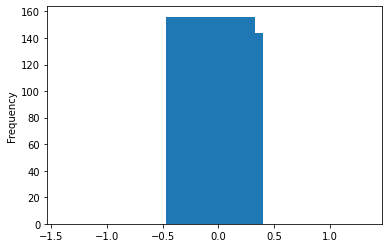

Accuracy: 0.3822
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.281492
Train Epoch: 2 [5760/60000 (10%)]	Loss: 2.270535
Train Epoch: 2 [11520/60000 (19%)]	Loss: 2.248452
Train Epoch: 2 [17280/60000 (29%)]	Loss: 2.248853
Train Epoch: 2 [23040/60000 (38%)]	Loss: 2.209548
Train Epoch: 2 [28800/60000 (48%)]	Loss: 2.178071
Train Epoch: 2 [34560/60000 (58%)]	Loss: 1.999739
Train Epoch: 2 [40320/60000 (67%)]	Loss: 1.404322
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.849721
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.932342
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.755438

Test set: Average loss: 0.0048, Accuracy: 8098/10000 (81%)



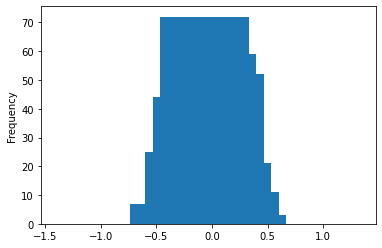

Accuracy: 0.8098
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.520865
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.596885
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.463350
Train Epoch: 3 [17280/60000 (29%)]	Loss: 0.380757
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.488017
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.782555
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.629712
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.331593
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.590634
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.364017
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.499982

Test set: Average loss: 0.0028, Accuracy: 8926/10000 (89%)



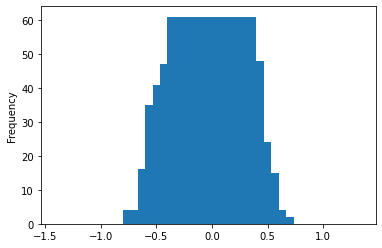

Accuracy: 0.8926
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.407507
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.441640
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.478177
Train Epoch: 4 [17280/60000 (29%)]	Loss: 0.385638
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.321505
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.656941
Train Epoch: 4 [34560/60000 (58%)]	Loss: 0.508158
Train Epoch: 4 [40320/60000 (67%)]	Loss: 0.371059
Train Epoch: 4 [46080/60000 (77%)]	Loss: 0.264074
Train Epoch: 4 [51840/60000 (86%)]	Loss: 0.400626
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.354493

Test set: Average loss: 0.0029, Accuracy: 8856/10000 (89%)



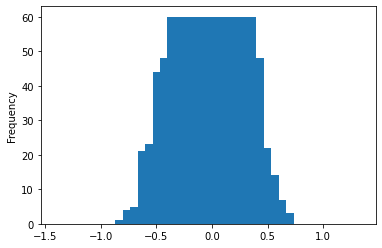

Accuracy: 0.8856
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.412843
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.408531
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.479668
Train Epoch: 5 [17280/60000 (29%)]	Loss: 0.274714
Train Epoch: 5 [23040/60000 (38%)]	Loss: 0.236795
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.338432
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.434682
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.242292
Train Epoch: 5 [46080/60000 (77%)]	Loss: 0.341710
Train Epoch: 5 [51840/60000 (86%)]	Loss: 0.215576
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.261626

Test set: Average loss: 0.0022, Accuracy: 9123/10000 (91%)



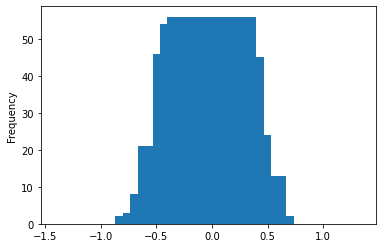

Accuracy: 0.9123
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.340257
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.280358
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.354835
Train Epoch: 6 [17280/60000 (29%)]	Loss: 0.441928
Train Epoch: 6 [23040/60000 (38%)]	Loss: 0.297903
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.281357
Train Epoch: 6 [34560/60000 (58%)]	Loss: 0.218700
Train Epoch: 6 [40320/60000 (67%)]	Loss: 0.356989
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.423575
Train Epoch: 6 [51840/60000 (86%)]	Loss: 0.232553
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.496144

Test set: Average loss: 0.0021, Accuracy: 9194/10000 (92%)



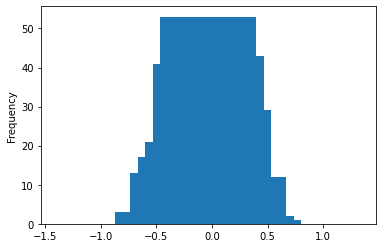

Accuracy: 0.9194
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.244482
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.384645
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.386311
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.391764
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.441116
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.226599
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.211707
Train Epoch: 7 [40320/60000 (67%)]	Loss: 0.303923
Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.371255
Train Epoch: 7 [51840/60000 (86%)]	Loss: 0.395382
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.140501

Test set: Average loss: 0.0023, Accuracy: 9100/10000 (91%)



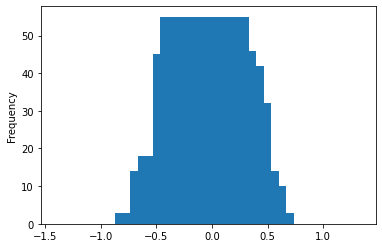

Accuracy: 0.91
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.272191
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.293161
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.355274
Train Epoch: 8 [17280/60000 (29%)]	Loss: 0.235446
Train Epoch: 8 [23040/60000 (38%)]	Loss: 0.378812
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.236010
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.254800
Train Epoch: 8 [40320/60000 (67%)]	Loss: 0.489251
Train Epoch: 8 [46080/60000 (77%)]	Loss: 0.234001
Train Epoch: 8 [51840/60000 (86%)]	Loss: 0.190448
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.275940

Test set: Average loss: 0.0023, Accuracy: 9091/10000 (91%)



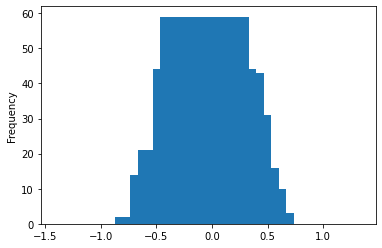

Accuracy: 0.9091
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.306894
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.362695
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.243800
Train Epoch: 9 [17280/60000 (29%)]	Loss: 0.207000
Train Epoch: 9 [23040/60000 (38%)]	Loss: 0.243442
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.155864
Train Epoch: 9 [34560/60000 (58%)]	Loss: 0.434702
Train Epoch: 9 [40320/60000 (67%)]	Loss: 0.261543
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.268314
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.214133
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.270249

Test set: Average loss: 0.0026, Accuracy: 8990/10000 (90%)



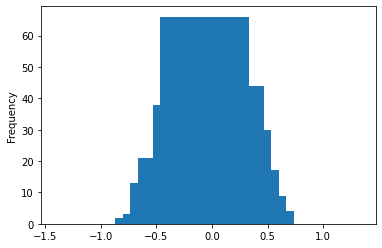

Accuracy: 0.899
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.304615
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.232907
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.240778
Train Epoch: 10 [17280/60000 (29%)]	Loss: 0.264882
Train Epoch: 10 [23040/60000 (38%)]	Loss: 0.253567
Train Epoch: 10 [28800/60000 (48%)]	Loss: 0.377334
Train Epoch: 10 [34560/60000 (58%)]	Loss: 0.345851
Train Epoch: 10 [40320/60000 (67%)]	Loss: 0.274520
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.268235
Train Epoch: 10 [51840/60000 (86%)]	Loss: 0.247087
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.304813

Test set: Average loss: 0.0022, Accuracy: 9151/10000 (92%)



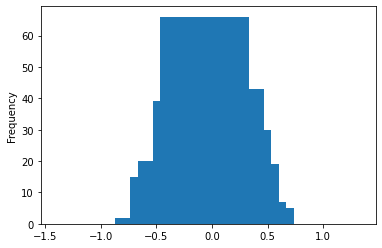

Accuracy: 0.9151
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.474807
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.376407
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.205112
Train Epoch: 11 [17280/60000 (29%)]	Loss: 0.214823
Train Epoch: 11 [23040/60000 (38%)]	Loss: 0.189688
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.306358
Train Epoch: 11 [34560/60000 (58%)]	Loss: 0.269502
Train Epoch: 11 [40320/60000 (67%)]	Loss: 0.393308
Train Epoch: 11 [46080/60000 (77%)]	Loss: 0.397998
Train Epoch: 11 [51840/60000 (86%)]	Loss: 0.232484
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.228839

Test set: Average loss: 0.0021, Accuracy: 9160/10000 (92%)



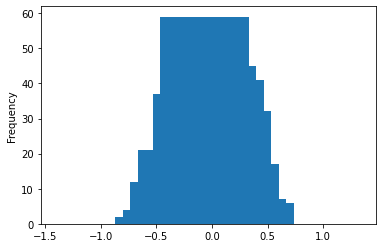

Accuracy: 0.916
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.294824
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.216951
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.467684
Train Epoch: 12 [17280/60000 (29%)]	Loss: 0.372329
Train Epoch: 12 [23040/60000 (38%)]	Loss: 0.125278
Train Epoch: 12 [28800/60000 (48%)]	Loss: 0.273256
Train Epoch: 12 [34560/60000 (58%)]	Loss: 0.236296
Train Epoch: 12 [40320/60000 (67%)]	Loss: 0.219913
Train Epoch: 12 [46080/60000 (77%)]	Loss: 0.293933
Train Epoch: 12 [51840/60000 (86%)]	Loss: 0.324613
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.175365

Test set: Average loss: 0.0020, Accuracy: 9213/10000 (92%)



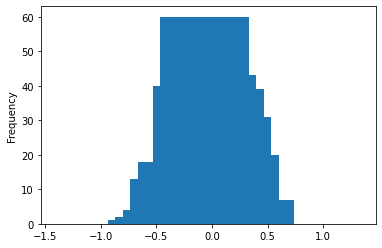

Accuracy: 0.9213
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.318724
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.229023
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.258294
Train Epoch: 13 [17280/60000 (29%)]	Loss: 0.282750
Train Epoch: 13 [23040/60000 (38%)]	Loss: 0.283416
Train Epoch: 13 [28800/60000 (48%)]	Loss: 0.198544
Train Epoch: 13 [34560/60000 (58%)]	Loss: 0.164286
Train Epoch: 13 [40320/60000 (67%)]	Loss: 0.293859
Train Epoch: 13 [46080/60000 (77%)]	Loss: 0.303210
Train Epoch: 13 [51840/60000 (86%)]	Loss: 0.200121
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.183317

Test set: Average loss: 0.0029, Accuracy: 8882/10000 (89%)



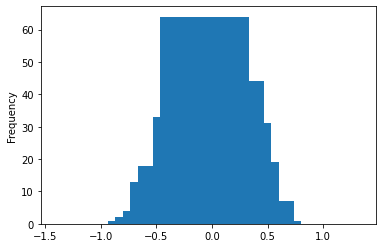

Accuracy: 0.8882
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.354854
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.296299
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.282551
Train Epoch: 14 [17280/60000 (29%)]	Loss: 0.175763
Train Epoch: 14 [23040/60000 (38%)]	Loss: 0.347144
Train Epoch: 14 [28800/60000 (48%)]	Loss: 0.270271
Train Epoch: 14 [34560/60000 (58%)]	Loss: 0.244670
Train Epoch: 14 [40320/60000 (67%)]	Loss: 0.348738
Train Epoch: 14 [46080/60000 (77%)]	Loss: 0.217657
Train Epoch: 14 [51840/60000 (86%)]	Loss: 0.169280
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.134056

Test set: Average loss: 0.0020, Accuracy: 9204/10000 (92%)



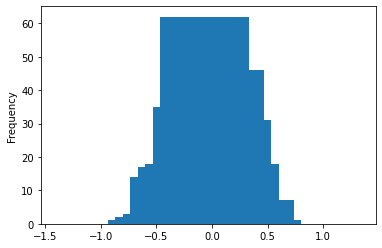

Accuracy: 0.9204
Train Epoch: 15 [0/60000 (0%)]	Loss: 0.254823
Train Epoch: 15 [5760/60000 (10%)]	Loss: 0.223600
Train Epoch: 15 [11520/60000 (19%)]	Loss: 0.375828
Train Epoch: 15 [17280/60000 (29%)]	Loss: 0.256825
Train Epoch: 15 [23040/60000 (38%)]	Loss: 0.374786
Train Epoch: 15 [28800/60000 (48%)]	Loss: 0.324814
Train Epoch: 15 [34560/60000 (58%)]	Loss: 0.179250
Train Epoch: 15 [40320/60000 (67%)]	Loss: 0.301263
Train Epoch: 15 [46080/60000 (77%)]	Loss: 0.347284
Train Epoch: 15 [51840/60000 (86%)]	Loss: 0.300954
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.275767

Test set: Average loss: 0.0020, Accuracy: 9227/10000 (92%)



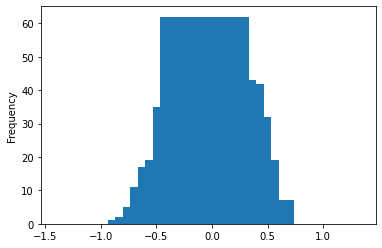

Accuracy: 0.9227
Train Epoch: 16 [0/60000 (0%)]	Loss: 0.183117
Train Epoch: 16 [5760/60000 (10%)]	Loss: 0.237438
Train Epoch: 16 [11520/60000 (19%)]	Loss: 0.201968
Train Epoch: 16 [17280/60000 (29%)]	Loss: 0.246486
Train Epoch: 16 [23040/60000 (38%)]	Loss: 0.332482
Train Epoch: 16 [28800/60000 (48%)]	Loss: 0.402231
Train Epoch: 16 [34560/60000 (58%)]	Loss: 0.197683
Train Epoch: 16 [40320/60000 (67%)]	Loss: 0.235716
Train Epoch: 16 [46080/60000 (77%)]	Loss: 0.347630
Train Epoch: 16 [51840/60000 (86%)]	Loss: 0.245064
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.208257

Test set: Average loss: 0.0021, Accuracy: 9182/10000 (92%)



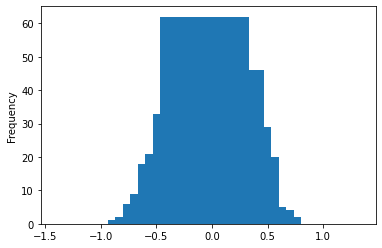

Accuracy: 0.9182
Train Epoch: 17 [0/60000 (0%)]	Loss: 0.232170
Train Epoch: 17 [5760/60000 (10%)]	Loss: 0.311418
Train Epoch: 17 [11520/60000 (19%)]	Loss: 0.274234
Train Epoch: 17 [17280/60000 (29%)]	Loss: 0.144963
Train Epoch: 17 [23040/60000 (38%)]	Loss: 0.315883
Train Epoch: 17 [28800/60000 (48%)]	Loss: 0.167080
Train Epoch: 17 [34560/60000 (58%)]	Loss: 0.378808
Train Epoch: 17 [40320/60000 (67%)]	Loss: 0.338811
Train Epoch: 17 [46080/60000 (77%)]	Loss: 0.364374
Train Epoch: 17 [51840/60000 (86%)]	Loss: 0.274910
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.234403

Test set: Average loss: 0.0022, Accuracy: 9124/10000 (91%)



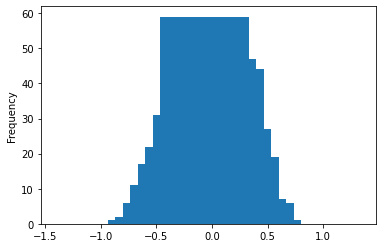

Accuracy: 0.9124
Train Epoch: 18 [0/60000 (0%)]	Loss: 0.181836
Train Epoch: 18 [5760/60000 (10%)]	Loss: 0.209883
Train Epoch: 18 [11520/60000 (19%)]	Loss: 0.352114
Train Epoch: 18 [17280/60000 (29%)]	Loss: 0.227724
Train Epoch: 18 [23040/60000 (38%)]	Loss: 0.362859
Train Epoch: 18 [28800/60000 (48%)]	Loss: 0.188348
Train Epoch: 18 [34560/60000 (58%)]	Loss: 0.215948
Train Epoch: 18 [40320/60000 (67%)]	Loss: 0.231605
Train Epoch: 18 [46080/60000 (77%)]	Loss: 0.311205
Train Epoch: 18 [51840/60000 (86%)]	Loss: 0.446607
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.297670

Test set: Average loss: 0.0019, Accuracy: 9223/10000 (92%)



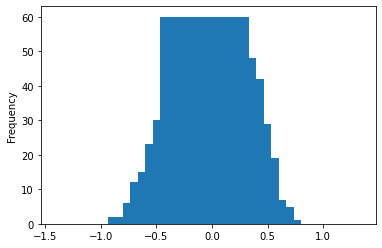

Accuracy: 0.9223
Train Epoch: 19 [0/60000 (0%)]	Loss: 0.174504
Train Epoch: 19 [5760/60000 (10%)]	Loss: 0.292053
Train Epoch: 19 [11520/60000 (19%)]	Loss: 0.401271
Train Epoch: 19 [17280/60000 (29%)]	Loss: 0.228611
Train Epoch: 19 [23040/60000 (38%)]	Loss: 0.378306
Train Epoch: 19 [28800/60000 (48%)]	Loss: 0.213654
Train Epoch: 19 [34560/60000 (58%)]	Loss: 0.263194
Train Epoch: 19 [40320/60000 (67%)]	Loss: 0.258049
Train Epoch: 19 [46080/60000 (77%)]	Loss: 0.161239
Train Epoch: 19 [51840/60000 (86%)]	Loss: 0.314895
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.416430

Test set: Average loss: 0.0020, Accuracy: 9249/10000 (92%)



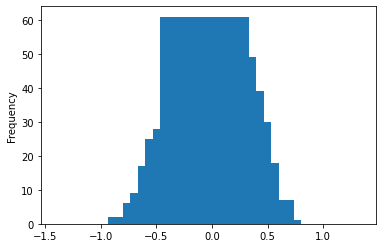

Accuracy: 0.9249
Train Epoch: 20 [0/60000 (0%)]	Loss: 0.383709
Train Epoch: 20 [5760/60000 (10%)]	Loss: 0.252439
Train Epoch: 20 [11520/60000 (19%)]	Loss: 0.187043
Train Epoch: 20 [17280/60000 (29%)]	Loss: 0.303207
Train Epoch: 20 [23040/60000 (38%)]	Loss: 0.268924
Train Epoch: 20 [28800/60000 (48%)]	Loss: 0.314997
Train Epoch: 20 [34560/60000 (58%)]	Loss: 0.194139
Train Epoch: 20 [40320/60000 (67%)]	Loss: 0.212471
Train Epoch: 20 [46080/60000 (77%)]	Loss: 0.204355
Train Epoch: 20 [51840/60000 (86%)]	Loss: 0.292376
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.226784

Test set: Average loss: 0.0022, Accuracy: 9112/10000 (91%)



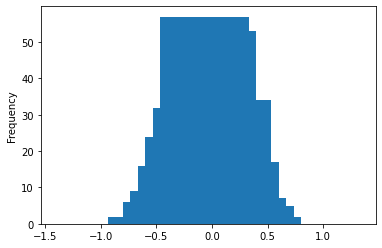

Accuracy: 0.9112
Train Epoch: 21 [0/60000 (0%)]	Loss: 0.338174
Train Epoch: 21 [5760/60000 (10%)]	Loss: 0.182027
Train Epoch: 21 [11520/60000 (19%)]	Loss: 0.337163
Train Epoch: 21 [17280/60000 (29%)]	Loss: 0.245788
Train Epoch: 21 [23040/60000 (38%)]	Loss: 0.232157
Train Epoch: 21 [28800/60000 (48%)]	Loss: 0.384565
Train Epoch: 21 [34560/60000 (58%)]	Loss: 0.233883
Train Epoch: 21 [40320/60000 (67%)]	Loss: 0.170112
Train Epoch: 21 [46080/60000 (77%)]	Loss: 0.248990
Train Epoch: 21 [51840/60000 (86%)]	Loss: 0.202915
Train Epoch: 21 [57600/60000 (96%)]	Loss: 0.292346

Test set: Average loss: 0.0022, Accuracy: 9136/10000 (91%)



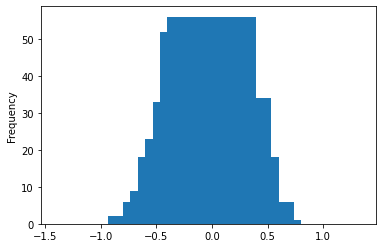

Accuracy: 0.9136
Train Epoch: 22 [0/60000 (0%)]	Loss: 0.288999
Train Epoch: 22 [5760/60000 (10%)]	Loss: 0.185892
Train Epoch: 22 [11520/60000 (19%)]	Loss: 0.216414
Train Epoch: 22 [17280/60000 (29%)]	Loss: 0.209227
Train Epoch: 22 [23040/60000 (38%)]	Loss: 0.261959
Train Epoch: 22 [28800/60000 (48%)]	Loss: 0.382006
Train Epoch: 22 [34560/60000 (58%)]	Loss: 0.181923
Train Epoch: 22 [40320/60000 (67%)]	Loss: 0.195159
Train Epoch: 22 [46080/60000 (77%)]	Loss: 0.310674
Train Epoch: 22 [51840/60000 (86%)]	Loss: 0.224136
Train Epoch: 22 [57600/60000 (96%)]	Loss: 0.172382

Test set: Average loss: 0.0021, Accuracy: 9204/10000 (92%)



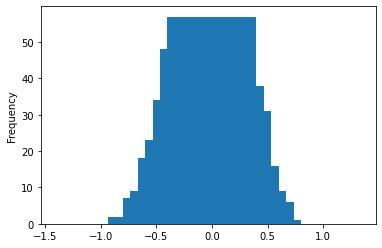

Accuracy: 0.9204
Train Epoch: 23 [0/60000 (0%)]	Loss: 0.285235
Train Epoch: 23 [5760/60000 (10%)]	Loss: 0.236154
Train Epoch: 23 [11520/60000 (19%)]	Loss: 0.235766
Train Epoch: 23 [17280/60000 (29%)]	Loss: 0.167262
Train Epoch: 23 [23040/60000 (38%)]	Loss: 0.327786
Train Epoch: 23 [28800/60000 (48%)]	Loss: 0.199157
Train Epoch: 23 [34560/60000 (58%)]	Loss: 0.309816
Train Epoch: 23 [40320/60000 (67%)]	Loss: 0.276768
Train Epoch: 23 [46080/60000 (77%)]	Loss: 0.157761
Train Epoch: 23 [51840/60000 (86%)]	Loss: 0.325948
Train Epoch: 23 [57600/60000 (96%)]	Loss: 0.283932

Test set: Average loss: 0.0020, Accuracy: 9213/10000 (92%)



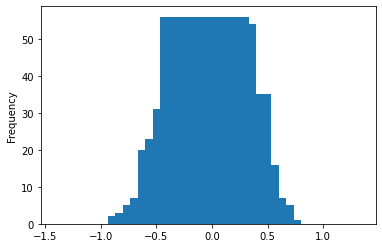

Accuracy: 0.9213
Train Epoch: 24 [0/60000 (0%)]	Loss: 0.272148
Train Epoch: 24 [5760/60000 (10%)]	Loss: 0.274496
Train Epoch: 24 [11520/60000 (19%)]	Loss: 0.171821
Train Epoch: 24 [17280/60000 (29%)]	Loss: 0.305474
Train Epoch: 24 [23040/60000 (38%)]	Loss: 0.234031
Train Epoch: 24 [28800/60000 (48%)]	Loss: 0.217795
Train Epoch: 24 [34560/60000 (58%)]	Loss: 0.346383
Train Epoch: 24 [40320/60000 (67%)]	Loss: 0.238775
Train Epoch: 24 [46080/60000 (77%)]	Loss: 0.110189
Train Epoch: 24 [51840/60000 (86%)]	Loss: 0.210892
Train Epoch: 24 [57600/60000 (96%)]	Loss: 0.271382

Test set: Average loss: 0.0023, Accuracy: 9089/10000 (91%)



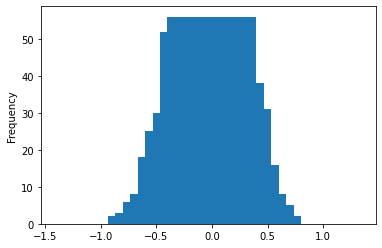

Accuracy: 0.9089
Train Epoch: 25 [0/60000 (0%)]	Loss: 0.249170
Train Epoch: 25 [5760/60000 (10%)]	Loss: 0.203615
Train Epoch: 25 [11520/60000 (19%)]	Loss: 0.274761
Train Epoch: 25 [17280/60000 (29%)]	Loss: 0.205839
Train Epoch: 25 [23040/60000 (38%)]	Loss: 0.207419
Train Epoch: 25 [28800/60000 (48%)]	Loss: 0.325303
Train Epoch: 25 [34560/60000 (58%)]	Loss: 0.294519
Train Epoch: 25 [40320/60000 (67%)]	Loss: 0.299698
Train Epoch: 25 [46080/60000 (77%)]	Loss: 0.430916
Train Epoch: 25 [51840/60000 (86%)]	Loss: 0.322161
Train Epoch: 25 [57600/60000 (96%)]	Loss: 0.305501

Test set: Average loss: 0.0022, Accuracy: 9159/10000 (92%)



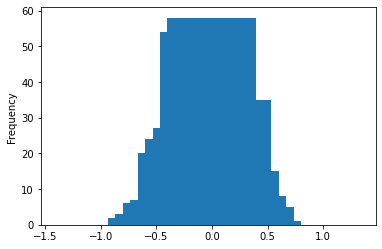

Accuracy: 0.9159
Train Epoch: 26 [0/60000 (0%)]	Loss: 0.262849
Train Epoch: 26 [5760/60000 (10%)]	Loss: 0.330821
Train Epoch: 26 [11520/60000 (19%)]	Loss: 0.238452
Train Epoch: 26 [17280/60000 (29%)]	Loss: 0.252857
Train Epoch: 26 [23040/60000 (38%)]	Loss: 0.209355
Train Epoch: 26 [28800/60000 (48%)]	Loss: 0.218181
Train Epoch: 26 [34560/60000 (58%)]	Loss: 0.321280
Train Epoch: 26 [40320/60000 (67%)]	Loss: 0.191915
Train Epoch: 26 [46080/60000 (77%)]	Loss: 0.259691
Train Epoch: 26 [51840/60000 (86%)]	Loss: 0.308965
Train Epoch: 26 [57600/60000 (96%)]	Loss: 0.248976

Test set: Average loss: 0.0021, Accuracy: 9193/10000 (92%)



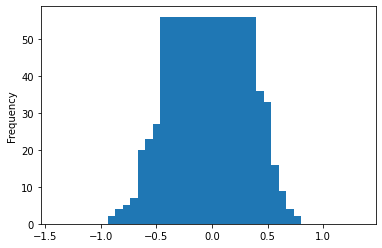

Accuracy: 0.9193
Train Epoch: 27 [0/60000 (0%)]	Loss: 0.212371
Train Epoch: 27 [5760/60000 (10%)]	Loss: 0.176470
Train Epoch: 27 [11520/60000 (19%)]	Loss: 0.173957
Train Epoch: 27 [17280/60000 (29%)]	Loss: 0.172569
Train Epoch: 27 [23040/60000 (38%)]	Loss: 0.233537
Train Epoch: 27 [28800/60000 (48%)]	Loss: 0.315351
Train Epoch: 27 [34560/60000 (58%)]	Loss: 0.262482
Train Epoch: 27 [40320/60000 (67%)]	Loss: 0.229716
Train Epoch: 27 [46080/60000 (77%)]	Loss: 0.269922
Train Epoch: 27 [51840/60000 (86%)]	Loss: 0.319576
Train Epoch: 27 [57600/60000 (96%)]	Loss: 0.280165

Test set: Average loss: 0.0024, Accuracy: 9097/10000 (91%)



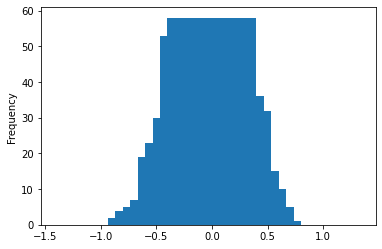

Accuracy: 0.9097
Train Epoch: 28 [0/60000 (0%)]	Loss: 0.277935
Train Epoch: 28 [5760/60000 (10%)]	Loss: 0.174554
Train Epoch: 28 [11520/60000 (19%)]	Loss: 0.307206
Train Epoch: 28 [17280/60000 (29%)]	Loss: 0.135347
Train Epoch: 28 [23040/60000 (38%)]	Loss: 0.265368
Train Epoch: 28 [28800/60000 (48%)]	Loss: 0.251361
Train Epoch: 28 [34560/60000 (58%)]	Loss: 0.211762
Train Epoch: 28 [40320/60000 (67%)]	Loss: 0.357585
Train Epoch: 28 [46080/60000 (77%)]	Loss: 0.235009
Train Epoch: 28 [51840/60000 (86%)]	Loss: 0.554666
Train Epoch: 28 [57600/60000 (96%)]	Loss: 0.268938

Test set: Average loss: 0.0020, Accuracy: 9271/10000 (93%)



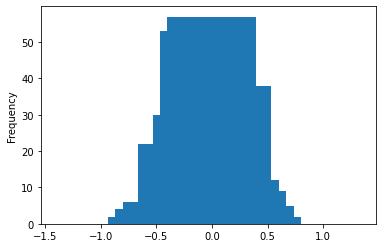

Accuracy: 0.9271
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.220875
Train Epoch: 29 [5760/60000 (10%)]	Loss: 0.307033
Train Epoch: 29 [11520/60000 (19%)]	Loss: 0.120002
Train Epoch: 29 [17280/60000 (29%)]	Loss: 0.259437
Train Epoch: 29 [23040/60000 (38%)]	Loss: 0.211841
Train Epoch: 29 [28800/60000 (48%)]	Loss: 0.274477
Train Epoch: 29 [34560/60000 (58%)]	Loss: 0.189985
Train Epoch: 29 [40320/60000 (67%)]	Loss: 0.340380
Train Epoch: 29 [46080/60000 (77%)]	Loss: 0.243973
Train Epoch: 29 [51840/60000 (86%)]	Loss: 0.221342
Train Epoch: 29 [57600/60000 (96%)]	Loss: 0.219317

Test set: Average loss: 0.0020, Accuracy: 9285/10000 (93%)



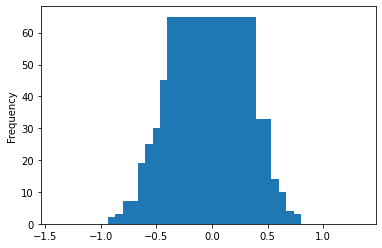

Accuracy: 0.9285
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.221168
Train Epoch: 30 [5760/60000 (10%)]	Loss: 0.375023
Train Epoch: 30 [11520/60000 (19%)]	Loss: 0.135552
Train Epoch: 30 [17280/60000 (29%)]	Loss: 0.175944
Train Epoch: 30 [23040/60000 (38%)]	Loss: 0.390518
Train Epoch: 30 [28800/60000 (48%)]	Loss: 0.161562
Train Epoch: 30 [34560/60000 (58%)]	Loss: 0.175199
Train Epoch: 30 [40320/60000 (67%)]	Loss: 0.218282
Train Epoch: 30 [46080/60000 (77%)]	Loss: 0.307711
Train Epoch: 30 [51840/60000 (86%)]	Loss: 0.200732
Train Epoch: 30 [57600/60000 (96%)]	Loss: 0.282828

Test set: Average loss: 0.0020, Accuracy: 9223/10000 (92%)



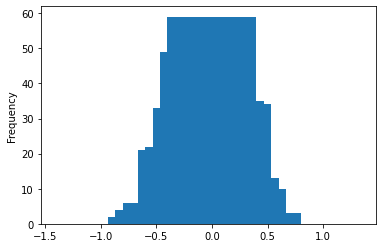

Accuracy: 0.9223
Train Epoch: 31 [0/60000 (0%)]	Loss: 0.275006
Train Epoch: 31 [5760/60000 (10%)]	Loss: 0.204940
Train Epoch: 31 [11520/60000 (19%)]	Loss: 0.206372
Train Epoch: 31 [17280/60000 (29%)]	Loss: 0.342821
Train Epoch: 31 [23040/60000 (38%)]	Loss: 0.139159
Train Epoch: 31 [28800/60000 (48%)]	Loss: 0.350861
Train Epoch: 31 [34560/60000 (58%)]	Loss: 0.189926
Train Epoch: 31 [40320/60000 (67%)]	Loss: 0.177910
Train Epoch: 31 [46080/60000 (77%)]	Loss: 0.287373
Train Epoch: 31 [51840/60000 (86%)]	Loss: 0.127307
Train Epoch: 31 [57600/60000 (96%)]	Loss: 0.307033

Test set: Average loss: 0.0019, Accuracy: 9287/10000 (93%)



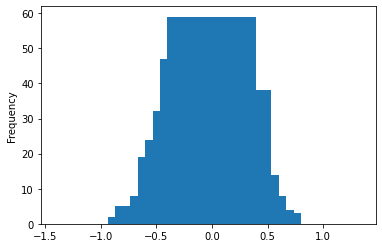

Accuracy: 0.9287
Train Epoch: 32 [0/60000 (0%)]	Loss: 0.253689
Train Epoch: 32 [5760/60000 (10%)]	Loss: 0.291170
Train Epoch: 32 [11520/60000 (19%)]	Loss: 0.249268
Train Epoch: 32 [17280/60000 (29%)]	Loss: 0.179803
Train Epoch: 32 [23040/60000 (38%)]	Loss: 0.236163
Train Epoch: 32 [28800/60000 (48%)]	Loss: 0.266215
Train Epoch: 32 [34560/60000 (58%)]	Loss: 0.267674
Train Epoch: 32 [40320/60000 (67%)]	Loss: 0.342604
Train Epoch: 32 [46080/60000 (77%)]	Loss: 0.460342
Train Epoch: 32 [51840/60000 (86%)]	Loss: 0.355060
Train Epoch: 32 [57600/60000 (96%)]	Loss: 0.281377

Test set: Average loss: 0.0022, Accuracy: 9187/10000 (92%)



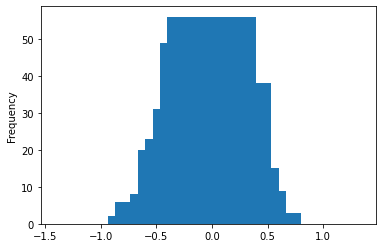

Accuracy: 0.9187
Train Epoch: 33 [0/60000 (0%)]	Loss: 0.561770
Train Epoch: 33 [5760/60000 (10%)]	Loss: 0.233742
Train Epoch: 33 [11520/60000 (19%)]	Loss: 0.258642
Train Epoch: 33 [17280/60000 (29%)]	Loss: 0.281159
Train Epoch: 33 [23040/60000 (38%)]	Loss: 0.416257
Train Epoch: 33 [28800/60000 (48%)]	Loss: 0.310610
Train Epoch: 33 [34560/60000 (58%)]	Loss: 0.238828
Train Epoch: 33 [40320/60000 (67%)]	Loss: 0.401901
Train Epoch: 33 [46080/60000 (77%)]	Loss: 0.226640
Train Epoch: 33 [51840/60000 (86%)]	Loss: 0.353384
Train Epoch: 33 [57600/60000 (96%)]	Loss: 0.229798

Test set: Average loss: 0.0020, Accuracy: 9241/10000 (92%)



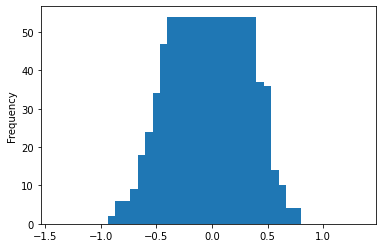

Accuracy: 0.9241
Train Epoch: 34 [0/60000 (0%)]	Loss: 0.154605
Train Epoch: 34 [5760/60000 (10%)]	Loss: 0.300802
Train Epoch: 34 [11520/60000 (19%)]	Loss: 0.251562
Train Epoch: 34 [17280/60000 (29%)]	Loss: 0.255201
Train Epoch: 34 [23040/60000 (38%)]	Loss: 0.356633
Train Epoch: 34 [28800/60000 (48%)]	Loss: 0.193746
Train Epoch: 34 [34560/60000 (58%)]	Loss: 0.219505
Train Epoch: 34 [40320/60000 (67%)]	Loss: 0.313712
Train Epoch: 34 [46080/60000 (77%)]	Loss: 0.147811
Train Epoch: 34 [51840/60000 (86%)]	Loss: 0.355642
Train Epoch: 34 [57600/60000 (96%)]	Loss: 0.216648

Test set: Average loss: 0.0019, Accuracy: 9300/10000 (93%)



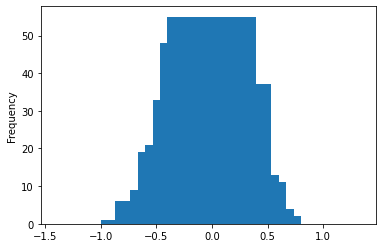

Accuracy: 0.93
Train Epoch: 35 [0/60000 (0%)]	Loss: 0.219475
Train Epoch: 35 [5760/60000 (10%)]	Loss: 0.158599
Train Epoch: 35 [11520/60000 (19%)]	Loss: 0.334948
Train Epoch: 35 [17280/60000 (29%)]	Loss: 0.161783
Train Epoch: 35 [23040/60000 (38%)]	Loss: 0.442718
Train Epoch: 35 [28800/60000 (48%)]	Loss: 0.538403
Train Epoch: 35 [34560/60000 (58%)]	Loss: 0.345245
Train Epoch: 35 [40320/60000 (67%)]	Loss: 0.284926
Train Epoch: 35 [46080/60000 (77%)]	Loss: 0.275576
Train Epoch: 35 [51840/60000 (86%)]	Loss: 0.180522
Train Epoch: 35 [57600/60000 (96%)]	Loss: 0.217962

Test set: Average loss: 0.0023, Accuracy: 9110/10000 (91%)



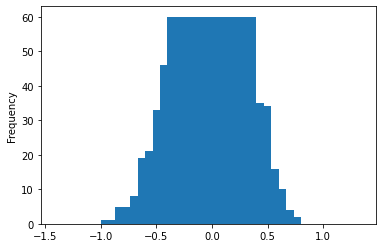

Accuracy: 0.911
Train Epoch: 36 [0/60000 (0%)]	Loss: 0.398696
Train Epoch: 36 [5760/60000 (10%)]	Loss: 0.262562
Train Epoch: 36 [11520/60000 (19%)]	Loss: 0.137575
Train Epoch: 36 [17280/60000 (29%)]	Loss: 0.314664
Train Epoch: 36 [23040/60000 (38%)]	Loss: 0.355144
Train Epoch: 36 [28800/60000 (48%)]	Loss: 0.212509
Train Epoch: 36 [34560/60000 (58%)]	Loss: 0.158699
Train Epoch: 36 [40320/60000 (67%)]	Loss: 0.227203
Train Epoch: 36 [46080/60000 (77%)]	Loss: 0.256018
Train Epoch: 36 [51840/60000 (86%)]	Loss: 0.176888
Train Epoch: 36 [57600/60000 (96%)]	Loss: 0.238192

Test set: Average loss: 0.0021, Accuracy: 9163/10000 (92%)



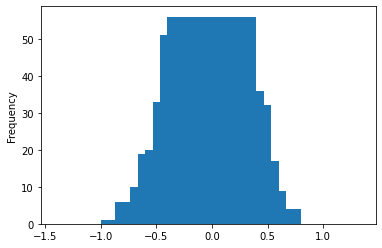

Accuracy: 0.9163
Train Epoch: 37 [0/60000 (0%)]	Loss: 0.288379
Train Epoch: 37 [5760/60000 (10%)]	Loss: 0.254524
Train Epoch: 37 [11520/60000 (19%)]	Loss: 0.352056
Train Epoch: 37 [17280/60000 (29%)]	Loss: 0.287173
Train Epoch: 37 [23040/60000 (38%)]	Loss: 0.248305
Train Epoch: 37 [28800/60000 (48%)]	Loss: 0.227814
Train Epoch: 37 [34560/60000 (58%)]	Loss: 0.253552
Train Epoch: 37 [40320/60000 (67%)]	Loss: 0.343254
Train Epoch: 37 [46080/60000 (77%)]	Loss: 0.335383
Train Epoch: 37 [51840/60000 (86%)]	Loss: 0.237624
Train Epoch: 37 [57600/60000 (96%)]	Loss: 0.109073

Test set: Average loss: 0.0018, Accuracy: 9306/10000 (93%)



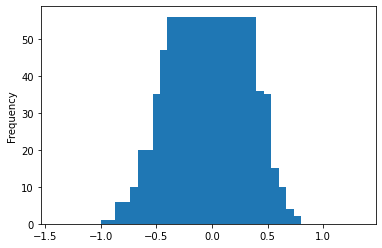

Accuracy: 0.9306
Train Epoch: 38 [0/60000 (0%)]	Loss: 0.116428
Train Epoch: 38 [5760/60000 (10%)]	Loss: 0.151695
Train Epoch: 38 [11520/60000 (19%)]	Loss: 0.234212
Train Epoch: 38 [17280/60000 (29%)]	Loss: 0.271143
Train Epoch: 38 [23040/60000 (38%)]	Loss: 0.503242
Train Epoch: 38 [28800/60000 (48%)]	Loss: 0.222725
Train Epoch: 38 [34560/60000 (58%)]	Loss: 0.258027
Train Epoch: 38 [40320/60000 (67%)]	Loss: 0.209545
Train Epoch: 38 [46080/60000 (77%)]	Loss: 0.160009
Train Epoch: 38 [51840/60000 (86%)]	Loss: 0.231443
Train Epoch: 38 [57600/60000 (96%)]	Loss: 0.229129

Test set: Average loss: 0.0019, Accuracy: 9271/10000 (93%)



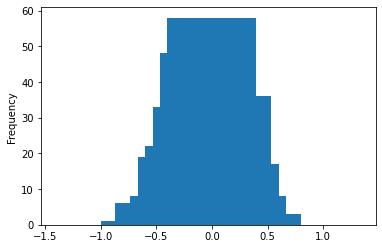

Accuracy: 0.9271
Train Epoch: 39 [0/60000 (0%)]	Loss: 0.258150
Train Epoch: 39 [5760/60000 (10%)]	Loss: 0.493113
Train Epoch: 39 [11520/60000 (19%)]	Loss: 0.259868
Train Epoch: 39 [17280/60000 (29%)]	Loss: 0.239817
Train Epoch: 39 [23040/60000 (38%)]	Loss: 0.252664
Train Epoch: 39 [28800/60000 (48%)]	Loss: 0.187234
Train Epoch: 39 [34560/60000 (58%)]	Loss: 0.333384
Train Epoch: 39 [40320/60000 (67%)]	Loss: 0.263308
Train Epoch: 39 [46080/60000 (77%)]	Loss: 0.313163
Train Epoch: 39 [51840/60000 (86%)]	Loss: 0.237507
Train Epoch: 39 [57600/60000 (96%)]	Loss: 0.099738

Test set: Average loss: 0.0019, Accuracy: 9255/10000 (93%)



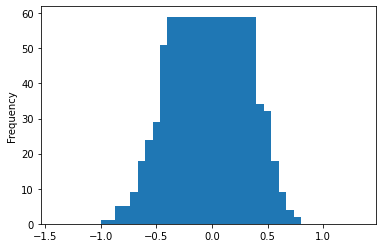

Accuracy: 0.9255
Train Epoch: 40 [0/60000 (0%)]	Loss: 0.292100
Train Epoch: 40 [5760/60000 (10%)]	Loss: 0.214704
Train Epoch: 40 [11520/60000 (19%)]	Loss: 0.174655
Train Epoch: 40 [17280/60000 (29%)]	Loss: 0.221273
Train Epoch: 40 [23040/60000 (38%)]	Loss: 0.452305
Train Epoch: 40 [28800/60000 (48%)]	Loss: 0.282185
Train Epoch: 40 [34560/60000 (58%)]	Loss: 0.212022
Train Epoch: 40 [40320/60000 (67%)]	Loss: 0.196915
Train Epoch: 40 [46080/60000 (77%)]	Loss: 0.212268
Train Epoch: 40 [51840/60000 (86%)]	Loss: 0.272989
Train Epoch: 40 [57600/60000 (96%)]	Loss: 0.177460

Test set: Average loss: 0.0022, Accuracy: 9166/10000 (92%)



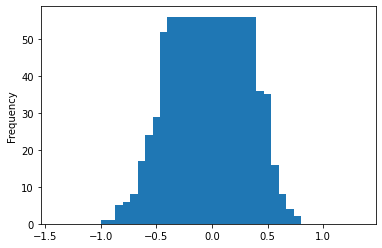

Accuracy: 0.9166
Train Epoch: 41 [0/60000 (0%)]	Loss: 0.257175
Train Epoch: 41 [5760/60000 (10%)]	Loss: 0.421490
Train Epoch: 41 [11520/60000 (19%)]	Loss: 0.249042
Train Epoch: 41 [17280/60000 (29%)]	Loss: 0.327211
Train Epoch: 41 [23040/60000 (38%)]	Loss: 0.135779
Train Epoch: 41 [28800/60000 (48%)]	Loss: 0.212425
Train Epoch: 41 [34560/60000 (58%)]	Loss: 0.536207
Train Epoch: 41 [40320/60000 (67%)]	Loss: 0.191407
Train Epoch: 41 [46080/60000 (77%)]	Loss: 0.275165
Train Epoch: 41 [51840/60000 (86%)]	Loss: 0.162662
Train Epoch: 41 [57600/60000 (96%)]	Loss: 0.236388

Test set: Average loss: 0.0031, Accuracy: 8818/10000 (88%)



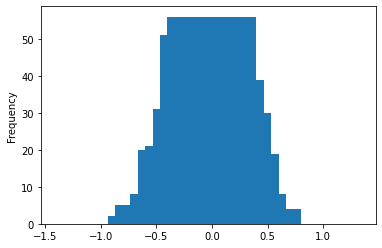

Accuracy: 0.8818
Train Epoch: 42 [0/60000 (0%)]	Loss: 0.429781
Train Epoch: 42 [5760/60000 (10%)]	Loss: 0.178295
Train Epoch: 42 [11520/60000 (19%)]	Loss: 0.142584
Train Epoch: 42 [17280/60000 (29%)]	Loss: 0.191692
Train Epoch: 42 [23040/60000 (38%)]	Loss: 0.432756
Train Epoch: 42 [28800/60000 (48%)]	Loss: 0.292484
Train Epoch: 42 [34560/60000 (58%)]	Loss: 0.181159
Train Epoch: 42 [40320/60000 (67%)]	Loss: 0.115779
Train Epoch: 42 [46080/60000 (77%)]	Loss: 0.149186
Train Epoch: 42 [51840/60000 (86%)]	Loss: 0.410801
Train Epoch: 42 [57600/60000 (96%)]	Loss: 0.360976

Test set: Average loss: 0.0022, Accuracy: 9135/10000 (91%)



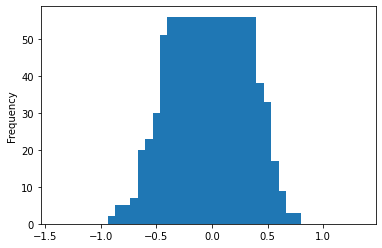

Accuracy: 0.9135
Train Epoch: 43 [0/60000 (0%)]	Loss: 0.188826
Train Epoch: 43 [5760/60000 (10%)]	Loss: 0.252929
Train Epoch: 43 [11520/60000 (19%)]	Loss: 0.266516
Train Epoch: 43 [17280/60000 (29%)]	Loss: 0.272405
Train Epoch: 43 [23040/60000 (38%)]	Loss: 0.287843
Train Epoch: 43 [28800/60000 (48%)]	Loss: 0.285706
Train Epoch: 43 [34560/60000 (58%)]	Loss: 0.244550
Train Epoch: 43 [40320/60000 (67%)]	Loss: 0.229563
Train Epoch: 43 [46080/60000 (77%)]	Loss: 0.505649
Train Epoch: 43 [51840/60000 (86%)]	Loss: 0.180406
Train Epoch: 43 [57600/60000 (96%)]	Loss: 0.348799

Test set: Average loss: 0.0019, Accuracy: 9275/10000 (93%)



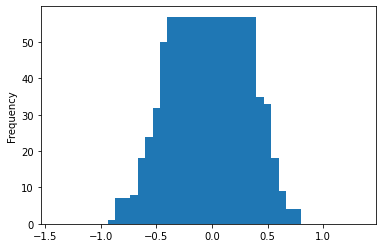

Accuracy: 0.9275
Train Epoch: 44 [0/60000 (0%)]	Loss: 0.328511
Train Epoch: 44 [5760/60000 (10%)]	Loss: 0.324271
Train Epoch: 44 [11520/60000 (19%)]	Loss: 0.200569
Train Epoch: 44 [17280/60000 (29%)]	Loss: 0.187238
Train Epoch: 44 [23040/60000 (38%)]	Loss: 0.233332
Train Epoch: 44 [28800/60000 (48%)]	Loss: 0.289379
Train Epoch: 44 [34560/60000 (58%)]	Loss: 0.174628
Train Epoch: 44 [40320/60000 (67%)]	Loss: 0.255898
Train Epoch: 44 [46080/60000 (77%)]	Loss: 0.270646
Train Epoch: 44 [51840/60000 (86%)]	Loss: 0.602482
Train Epoch: 44 [57600/60000 (96%)]	Loss: 0.241706

Test set: Average loss: 0.0021, Accuracy: 9206/10000 (92%)



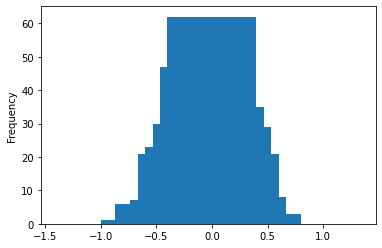

Accuracy: 0.9206
Train Epoch: 45 [0/60000 (0%)]	Loss: 0.215403
Train Epoch: 45 [5760/60000 (10%)]	Loss: 0.208736
Train Epoch: 45 [11520/60000 (19%)]	Loss: 0.330738
Train Epoch: 45 [17280/60000 (29%)]	Loss: 0.197448
Train Epoch: 45 [23040/60000 (38%)]	Loss: 0.245518
Train Epoch: 45 [28800/60000 (48%)]	Loss: 0.151815
Train Epoch: 45 [34560/60000 (58%)]	Loss: 0.174941
Train Epoch: 45 [40320/60000 (67%)]	Loss: 0.223688
Train Epoch: 45 [46080/60000 (77%)]	Loss: 0.391954
Train Epoch: 45 [51840/60000 (86%)]	Loss: 0.156796
Train Epoch: 45 [57600/60000 (96%)]	Loss: 0.161643

Test set: Average loss: 0.0020, Accuracy: 9259/10000 (93%)



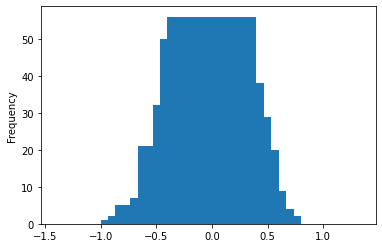

Accuracy: 0.9259
Train Epoch: 46 [0/60000 (0%)]	Loss: 0.178037
Train Epoch: 46 [5760/60000 (10%)]	Loss: 0.186165
Train Epoch: 46 [11520/60000 (19%)]	Loss: 0.178155
Train Epoch: 46 [17280/60000 (29%)]	Loss: 0.199287
Train Epoch: 46 [23040/60000 (38%)]	Loss: 0.195604
Train Epoch: 46 [28800/60000 (48%)]	Loss: 0.172418
Train Epoch: 46 [34560/60000 (58%)]	Loss: 0.275804
Train Epoch: 46 [40320/60000 (67%)]	Loss: 0.259711
Train Epoch: 46 [46080/60000 (77%)]	Loss: 0.237444
Train Epoch: 46 [51840/60000 (86%)]	Loss: 0.199491
Train Epoch: 46 [57600/60000 (96%)]	Loss: 0.266356

Test set: Average loss: 0.0019, Accuracy: 9311/10000 (93%)



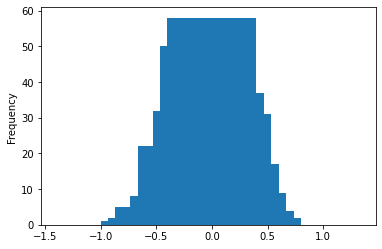

Accuracy: 0.9311
Train Epoch: 47 [0/60000 (0%)]	Loss: 0.176838
Train Epoch: 47 [5760/60000 (10%)]	Loss: 0.169144
Train Epoch: 47 [11520/60000 (19%)]	Loss: 0.143199
Train Epoch: 47 [17280/60000 (29%)]	Loss: 0.271835
Train Epoch: 47 [23040/60000 (38%)]	Loss: 0.273562
Train Epoch: 47 [28800/60000 (48%)]	Loss: 0.349857
Train Epoch: 47 [34560/60000 (58%)]	Loss: 0.327385
Train Epoch: 47 [40320/60000 (67%)]	Loss: 0.136890
Train Epoch: 47 [46080/60000 (77%)]	Loss: 0.287093
Train Epoch: 47 [51840/60000 (86%)]	Loss: 0.330416
Train Epoch: 47 [57600/60000 (96%)]	Loss: 0.246596

Test set: Average loss: 0.0019, Accuracy: 9271/10000 (93%)



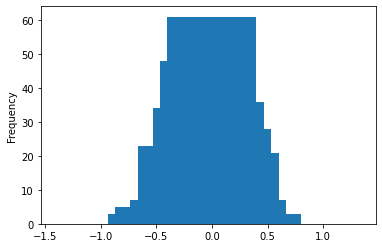

Accuracy: 0.9271
Train Epoch: 48 [0/60000 (0%)]	Loss: 0.184405
Train Epoch: 48 [5760/60000 (10%)]	Loss: 0.119305
Train Epoch: 48 [11520/60000 (19%)]	Loss: 0.407183
Train Epoch: 48 [17280/60000 (29%)]	Loss: 0.302179
Train Epoch: 48 [23040/60000 (38%)]	Loss: 0.206622
Train Epoch: 48 [28800/60000 (48%)]	Loss: 0.158030
Train Epoch: 48 [34560/60000 (58%)]	Loss: 0.220100
Train Epoch: 48 [40320/60000 (67%)]	Loss: 0.242439
Train Epoch: 48 [46080/60000 (77%)]	Loss: 0.280111
Train Epoch: 48 [51840/60000 (86%)]	Loss: 0.225431
Train Epoch: 48 [57600/60000 (96%)]	Loss: 0.177383

Test set: Average loss: 0.0018, Accuracy: 9279/10000 (93%)



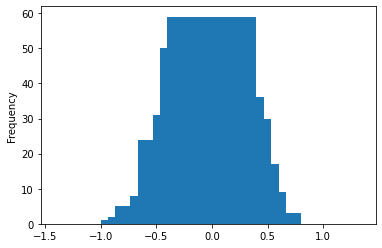

Accuracy: 0.9279
Train Epoch: 49 [0/60000 (0%)]	Loss: 0.155639
Train Epoch: 49 [5760/60000 (10%)]	Loss: 0.289856
Train Epoch: 49 [11520/60000 (19%)]	Loss: 0.259465
Train Epoch: 49 [17280/60000 (29%)]	Loss: 0.256428
Train Epoch: 49 [23040/60000 (38%)]	Loss: 0.279728
Train Epoch: 49 [28800/60000 (48%)]	Loss: 0.190716
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.302845
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.385507
Train Epoch: 49 [46080/60000 (77%)]	Loss: 0.281907
Train Epoch: 49 [51840/60000 (86%)]	Loss: 0.135769
Train Epoch: 49 [57600/60000 (96%)]	Loss: 0.276130

Test set: Average loss: 0.0019, Accuracy: 9319/10000 (93%)



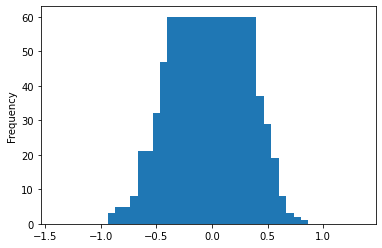

Accuracy: 0.9319
Train Epoch: 50 [0/60000 (0%)]	Loss: 0.225158
Train Epoch: 50 [5760/60000 (10%)]	Loss: 0.188566
Train Epoch: 50 [11520/60000 (19%)]	Loss: 0.271318
Train Epoch: 50 [17280/60000 (29%)]	Loss: 0.323468
Train Epoch: 50 [23040/60000 (38%)]	Loss: 0.243027
Train Epoch: 50 [28800/60000 (48%)]	Loss: 0.159753
Train Epoch: 50 [34560/60000 (58%)]	Loss: 0.235595
Train Epoch: 50 [40320/60000 (67%)]	Loss: 0.200865
Train Epoch: 50 [46080/60000 (77%)]	Loss: 0.294922
Train Epoch: 50 [51840/60000 (86%)]	Loss: 0.177298
Train Epoch: 50 [57600/60000 (96%)]	Loss: 0.261689

Test set: Average loss: 0.0020, Accuracy: 9254/10000 (93%)



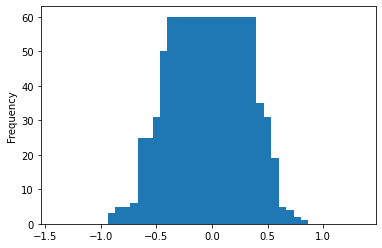

Accuracy: 0.9254
Train Epoch: 51 [0/60000 (0%)]	Loss: 0.133174
Train Epoch: 51 [5760/60000 (10%)]	Loss: 0.184712
Train Epoch: 51 [11520/60000 (19%)]	Loss: 0.254753
Train Epoch: 51 [17280/60000 (29%)]	Loss: 0.243868
Train Epoch: 51 [23040/60000 (38%)]	Loss: 0.266964
Train Epoch: 51 [28800/60000 (48%)]	Loss: 0.120900
Train Epoch: 51 [34560/60000 (58%)]	Loss: 0.291340
Train Epoch: 51 [40320/60000 (67%)]	Loss: 0.216591
Train Epoch: 51 [46080/60000 (77%)]	Loss: 0.323770
Train Epoch: 51 [51840/60000 (86%)]	Loss: 0.282080
Train Epoch: 51 [57600/60000 (96%)]	Loss: 0.235225

Test set: Average loss: 0.0019, Accuracy: 9281/10000 (93%)



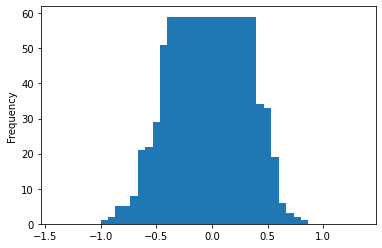

Accuracy: 0.9281
Train Epoch: 52 [0/60000 (0%)]	Loss: 0.210043
Train Epoch: 52 [5760/60000 (10%)]	Loss: 0.216968
Train Epoch: 52 [11520/60000 (19%)]	Loss: 0.250214
Train Epoch: 52 [17280/60000 (29%)]	Loss: 0.218431
Train Epoch: 52 [23040/60000 (38%)]	Loss: 0.139870
Train Epoch: 52 [28800/60000 (48%)]	Loss: 0.119746
Train Epoch: 52 [34560/60000 (58%)]	Loss: 0.309424
Train Epoch: 52 [40320/60000 (67%)]	Loss: 0.200312
Train Epoch: 52 [46080/60000 (77%)]	Loss: 0.188060
Train Epoch: 52 [51840/60000 (86%)]	Loss: 0.195394
Train Epoch: 52 [57600/60000 (96%)]	Loss: 0.203636

Test set: Average loss: 0.0017, Accuracy: 9345/10000 (93%)



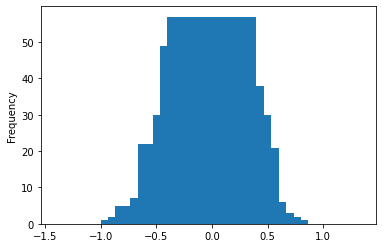

Accuracy: 0.9345
Train Epoch: 53 [0/60000 (0%)]	Loss: 0.261590
Train Epoch: 53 [5760/60000 (10%)]	Loss: 0.419515
Train Epoch: 53 [11520/60000 (19%)]	Loss: 0.160970
Train Epoch: 53 [17280/60000 (29%)]	Loss: 0.233917
Train Epoch: 53 [23040/60000 (38%)]	Loss: 0.144062
Train Epoch: 53 [28800/60000 (48%)]	Loss: 0.244326
Train Epoch: 53 [34560/60000 (58%)]	Loss: 0.278612
Train Epoch: 53 [40320/60000 (67%)]	Loss: 0.150252
Train Epoch: 53 [46080/60000 (77%)]	Loss: 0.157107
Train Epoch: 53 [51840/60000 (86%)]	Loss: 0.161898
Train Epoch: 53 [57600/60000 (96%)]	Loss: 0.277491

Test set: Average loss: 0.0019, Accuracy: 9288/10000 (93%)



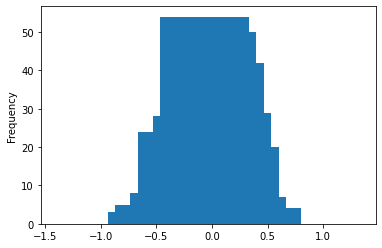

Accuracy: 0.9288
Train Epoch: 54 [0/60000 (0%)]	Loss: 0.316990
Train Epoch: 54 [5760/60000 (10%)]	Loss: 0.265069
Train Epoch: 54 [11520/60000 (19%)]	Loss: 0.280148
Train Epoch: 54 [17280/60000 (29%)]	Loss: 0.513012
Train Epoch: 54 [23040/60000 (38%)]	Loss: 0.105269
Train Epoch: 54 [28800/60000 (48%)]	Loss: 0.202967
Train Epoch: 54 [34560/60000 (58%)]	Loss: 0.257699
Train Epoch: 54 [40320/60000 (67%)]	Loss: 0.343308
Train Epoch: 54 [46080/60000 (77%)]	Loss: 0.236674
Train Epoch: 54 [51840/60000 (86%)]	Loss: 0.246408
Train Epoch: 54 [57600/60000 (96%)]	Loss: 0.127656

Test set: Average loss: 0.0020, Accuracy: 9224/10000 (92%)



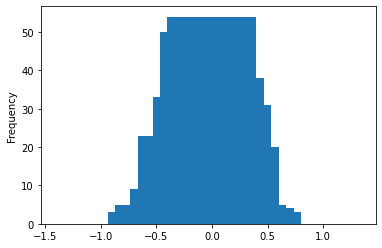

Accuracy: 0.9224
Train Epoch: 55 [0/60000 (0%)]	Loss: 0.186925
Train Epoch: 55 [5760/60000 (10%)]	Loss: 0.108743
Train Epoch: 55 [11520/60000 (19%)]	Loss: 0.212160
Train Epoch: 55 [17280/60000 (29%)]	Loss: 0.253233
Train Epoch: 55 [23040/60000 (38%)]	Loss: 0.208549
Train Epoch: 55 [28800/60000 (48%)]	Loss: 0.293257
Train Epoch: 55 [34560/60000 (58%)]	Loss: 0.229988
Train Epoch: 55 [40320/60000 (67%)]	Loss: 0.236737
Train Epoch: 55 [46080/60000 (77%)]	Loss: 0.234931
Train Epoch: 55 [51840/60000 (86%)]	Loss: 0.214720
Train Epoch: 55 [57600/60000 (96%)]	Loss: 0.277584

Test set: Average loss: 0.0018, Accuracy: 9278/10000 (93%)



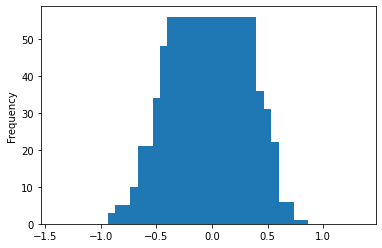

Accuracy: 0.9278
Train Epoch: 56 [0/60000 (0%)]	Loss: 0.220314
Train Epoch: 56 [5760/60000 (10%)]	Loss: 0.363886
Train Epoch: 56 [11520/60000 (19%)]	Loss: 0.363207
Train Epoch: 56 [17280/60000 (29%)]	Loss: 0.248361
Train Epoch: 56 [23040/60000 (38%)]	Loss: 0.187816
Train Epoch: 56 [28800/60000 (48%)]	Loss: 0.318790
Train Epoch: 56 [34560/60000 (58%)]	Loss: 0.333187
Train Epoch: 56 [40320/60000 (67%)]	Loss: 0.258637
Train Epoch: 56 [46080/60000 (77%)]	Loss: 0.186931
Train Epoch: 56 [51840/60000 (86%)]	Loss: 0.197534
Train Epoch: 56 [57600/60000 (96%)]	Loss: 0.334403

Test set: Average loss: 0.0019, Accuracy: 9297/10000 (93%)



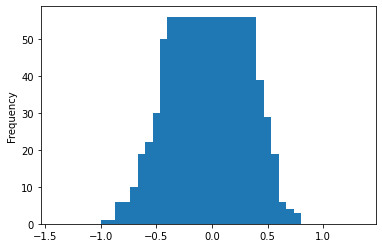

Accuracy: 0.9297
Train Epoch: 57 [0/60000 (0%)]	Loss: 0.109183
Train Epoch: 57 [5760/60000 (10%)]	Loss: 0.243465
Train Epoch: 57 [11520/60000 (19%)]	Loss: 0.218740
Train Epoch: 57 [17280/60000 (29%)]	Loss: 0.186202
Train Epoch: 57 [23040/60000 (38%)]	Loss: 0.139618
Train Epoch: 57 [28800/60000 (48%)]	Loss: 0.160983
Train Epoch: 57 [34560/60000 (58%)]	Loss: 0.306514
Train Epoch: 57 [40320/60000 (67%)]	Loss: 0.331192
Train Epoch: 57 [46080/60000 (77%)]	Loss: 0.263840
Train Epoch: 57 [51840/60000 (86%)]	Loss: 0.296175
Train Epoch: 57 [57600/60000 (96%)]	Loss: 0.256163

Test set: Average loss: 0.0020, Accuracy: 9201/10000 (92%)



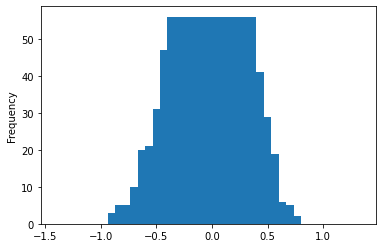

Accuracy: 0.9201
Train Epoch: 58 [0/60000 (0%)]	Loss: 0.283104
Train Epoch: 58 [5760/60000 (10%)]	Loss: 0.204093
Train Epoch: 58 [11520/60000 (19%)]	Loss: 0.183098
Train Epoch: 58 [17280/60000 (29%)]	Loss: 0.205167
Train Epoch: 58 [23040/60000 (38%)]	Loss: 0.104938
Train Epoch: 58 [28800/60000 (48%)]	Loss: 0.160513
Train Epoch: 58 [34560/60000 (58%)]	Loss: 0.135219
Train Epoch: 58 [40320/60000 (67%)]	Loss: 0.162071
Train Epoch: 58 [46080/60000 (77%)]	Loss: 0.146655
Train Epoch: 58 [51840/60000 (86%)]	Loss: 0.329416
Train Epoch: 58 [57600/60000 (96%)]	Loss: 0.410170

Test set: Average loss: 0.0018, Accuracy: 9323/10000 (93%)



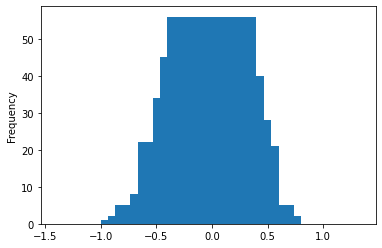

Accuracy: 0.9323
Train Epoch: 59 [0/60000 (0%)]	Loss: 0.239835
Train Epoch: 59 [5760/60000 (10%)]	Loss: 0.297451
Train Epoch: 59 [11520/60000 (19%)]	Loss: 0.301594
Train Epoch: 59 [17280/60000 (29%)]	Loss: 0.171047
Train Epoch: 59 [23040/60000 (38%)]	Loss: 0.282708
Train Epoch: 59 [28800/60000 (48%)]	Loss: 0.249642
Train Epoch: 59 [34560/60000 (58%)]	Loss: 0.240568
Train Epoch: 59 [40320/60000 (67%)]	Loss: 0.297698
Train Epoch: 59 [46080/60000 (77%)]	Loss: 0.134630
Train Epoch: 59 [51840/60000 (86%)]	Loss: 0.097868
Train Epoch: 59 [57600/60000 (96%)]	Loss: 0.271932

Test set: Average loss: 0.0018, Accuracy: 9324/10000 (93%)



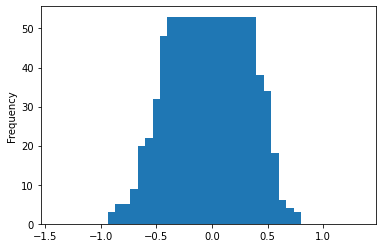

Accuracy: 0.9324
Train Epoch: 60 [0/60000 (0%)]	Loss: 0.333077
Train Epoch: 60 [5760/60000 (10%)]	Loss: 0.230928
Train Epoch: 60 [11520/60000 (19%)]	Loss: 0.175117
Train Epoch: 60 [17280/60000 (29%)]	Loss: 0.135594
Train Epoch: 60 [23040/60000 (38%)]	Loss: 0.200999
Train Epoch: 60 [28800/60000 (48%)]	Loss: 0.164960
Train Epoch: 60 [34560/60000 (58%)]	Loss: 0.357286
Train Epoch: 60 [40320/60000 (67%)]	Loss: 0.260256
Train Epoch: 60 [46080/60000 (77%)]	Loss: 0.235614
Train Epoch: 60 [51840/60000 (86%)]	Loss: 0.307132
Train Epoch: 60 [57600/60000 (96%)]	Loss: 0.247407

Test set: Average loss: 0.0017, Accuracy: 9361/10000 (94%)



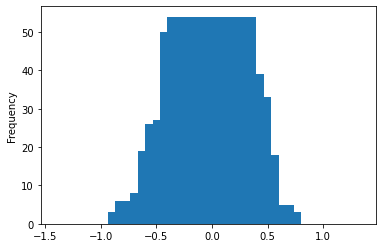

Accuracy: 0.9361
Train Epoch: 61 [0/60000 (0%)]	Loss: 0.196388
Train Epoch: 61 [5760/60000 (10%)]	Loss: 0.252192
Train Epoch: 61 [11520/60000 (19%)]	Loss: 0.146698
Train Epoch: 61 [17280/60000 (29%)]	Loss: 0.160700
Train Epoch: 61 [23040/60000 (38%)]	Loss: 0.125122
Train Epoch: 61 [28800/60000 (48%)]	Loss: 0.236032
Train Epoch: 61 [34560/60000 (58%)]	Loss: 0.517525
Train Epoch: 61 [40320/60000 (67%)]	Loss: 0.275788
Train Epoch: 61 [46080/60000 (77%)]	Loss: 0.241906
Train Epoch: 61 [51840/60000 (86%)]	Loss: 0.284871
Train Epoch: 61 [57600/60000 (96%)]	Loss: 0.151166

Test set: Average loss: 0.0018, Accuracy: 9292/10000 (93%)



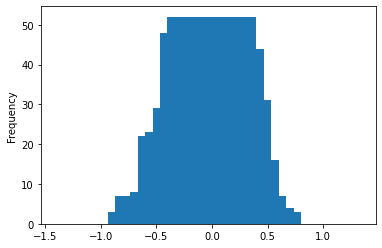

Accuracy: 0.9292
Train Epoch: 62 [0/60000 (0%)]	Loss: 0.228750
Train Epoch: 62 [5760/60000 (10%)]	Loss: 0.237085
Train Epoch: 62 [11520/60000 (19%)]	Loss: 0.162802
Train Epoch: 62 [17280/60000 (29%)]	Loss: 0.255625
Train Epoch: 62 [23040/60000 (38%)]	Loss: 0.171970
Train Epoch: 62 [28800/60000 (48%)]	Loss: 0.132988
Train Epoch: 62 [34560/60000 (58%)]	Loss: 0.223989
Train Epoch: 62 [40320/60000 (67%)]	Loss: 0.239484
Train Epoch: 62 [46080/60000 (77%)]	Loss: 0.231734
Train Epoch: 62 [51840/60000 (86%)]	Loss: 0.224715
Train Epoch: 62 [57600/60000 (96%)]	Loss: 0.219654

Test set: Average loss: 0.0018, Accuracy: 9346/10000 (93%)



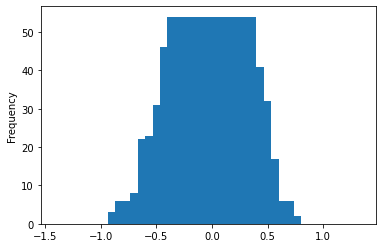

Accuracy: 0.9346
Train Epoch: 63 [0/60000 (0%)]	Loss: 0.132669
Train Epoch: 63 [5760/60000 (10%)]	Loss: 0.216729
Train Epoch: 63 [11520/60000 (19%)]	Loss: 0.197307
Train Epoch: 63 [17280/60000 (29%)]	Loss: 0.233566
Train Epoch: 63 [23040/60000 (38%)]	Loss: 0.282831
Train Epoch: 63 [28800/60000 (48%)]	Loss: 0.342628
Train Epoch: 63 [34560/60000 (58%)]	Loss: 0.234151
Train Epoch: 63 [40320/60000 (67%)]	Loss: 0.225733
Train Epoch: 63 [46080/60000 (77%)]	Loss: 0.223362
Train Epoch: 63 [51840/60000 (86%)]	Loss: 0.249666
Train Epoch: 63 [57600/60000 (96%)]	Loss: 0.166944

Test set: Average loss: 0.0022, Accuracy: 9177/10000 (92%)



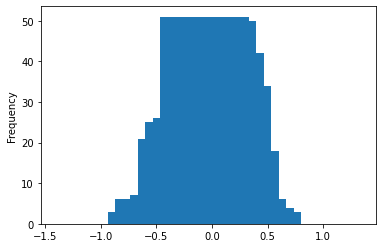

Accuracy: 0.9177
Train Epoch: 64 [0/60000 (0%)]	Loss: 0.188821
Train Epoch: 64 [5760/60000 (10%)]	Loss: 0.387580
Train Epoch: 64 [11520/60000 (19%)]	Loss: 0.332354
Train Epoch: 64 [17280/60000 (29%)]	Loss: 0.297726
Train Epoch: 64 [23040/60000 (38%)]	Loss: 0.332865
Train Epoch: 64 [28800/60000 (48%)]	Loss: 0.247300
Train Epoch: 64 [34560/60000 (58%)]	Loss: 0.290118
Train Epoch: 64 [40320/60000 (67%)]	Loss: 0.344910
Train Epoch: 64 [46080/60000 (77%)]	Loss: 0.226173
Train Epoch: 64 [51840/60000 (86%)]	Loss: 0.188924
Train Epoch: 64 [57600/60000 (96%)]	Loss: 0.214643

Test set: Average loss: 0.0018, Accuracy: 9329/10000 (93%)



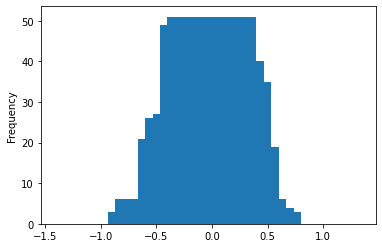

Accuracy: 0.9329
Train Epoch: 65 [0/60000 (0%)]	Loss: 0.149443
Train Epoch: 65 [5760/60000 (10%)]	Loss: 0.180504
Train Epoch: 65 [11520/60000 (19%)]	Loss: 0.232094
Train Epoch: 65 [17280/60000 (29%)]	Loss: 0.114120
Train Epoch: 65 [23040/60000 (38%)]	Loss: 0.148924
Train Epoch: 65 [28800/60000 (48%)]	Loss: 0.148406
Train Epoch: 65 [34560/60000 (58%)]	Loss: 0.221294
Train Epoch: 65 [40320/60000 (67%)]	Loss: 0.203089
Train Epoch: 65 [46080/60000 (77%)]	Loss: 0.302682
Train Epoch: 65 [51840/60000 (86%)]	Loss: 0.304688
Train Epoch: 65 [57600/60000 (96%)]	Loss: 0.261856

Test set: Average loss: 0.0019, Accuracy: 9289/10000 (93%)



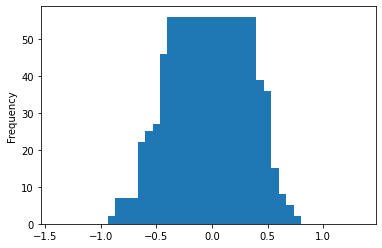

Accuracy: 0.9289
Train Epoch: 66 [0/60000 (0%)]	Loss: 0.279032
Train Epoch: 66 [5760/60000 (10%)]	Loss: 0.358021
Train Epoch: 66 [11520/60000 (19%)]	Loss: 0.233524
Train Epoch: 66 [17280/60000 (29%)]	Loss: 0.224048
Train Epoch: 66 [23040/60000 (38%)]	Loss: 0.130363
Train Epoch: 66 [28800/60000 (48%)]	Loss: 0.322775
Train Epoch: 66 [34560/60000 (58%)]	Loss: 0.323451
Train Epoch: 66 [40320/60000 (67%)]	Loss: 0.167271
Train Epoch: 66 [46080/60000 (77%)]	Loss: 0.180035
Train Epoch: 66 [51840/60000 (86%)]	Loss: 0.377923
Train Epoch: 66 [57600/60000 (96%)]	Loss: 0.185875

Test set: Average loss: 0.0022, Accuracy: 9120/10000 (91%)



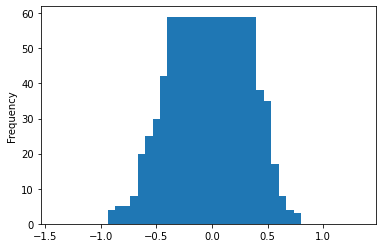

Accuracy: 0.912
Train Epoch: 67 [0/60000 (0%)]	Loss: 0.233316
Train Epoch: 67 [5760/60000 (10%)]	Loss: 0.421420
Train Epoch: 67 [11520/60000 (19%)]	Loss: 0.208255
Train Epoch: 67 [17280/60000 (29%)]	Loss: 0.180933
Train Epoch: 67 [23040/60000 (38%)]	Loss: 0.156570
Train Epoch: 67 [28800/60000 (48%)]	Loss: 0.218995
Train Epoch: 67 [34560/60000 (58%)]	Loss: 0.168504
Train Epoch: 67 [40320/60000 (67%)]	Loss: 0.189173
Train Epoch: 67 [46080/60000 (77%)]	Loss: 0.266529
Train Epoch: 67 [51840/60000 (86%)]	Loss: 0.163184
Train Epoch: 67 [57600/60000 (96%)]	Loss: 0.293131

Test set: Average loss: 0.0018, Accuracy: 9322/10000 (93%)



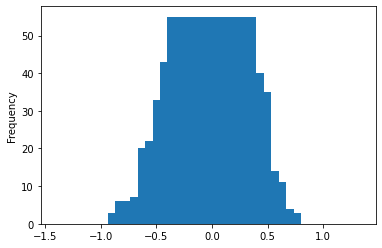

Accuracy: 0.9322
Train Epoch: 68 [0/60000 (0%)]	Loss: 0.318524
Train Epoch: 68 [5760/60000 (10%)]	Loss: 0.191374
Train Epoch: 68 [11520/60000 (19%)]	Loss: 0.184984
Train Epoch: 68 [17280/60000 (29%)]	Loss: 0.226202
Train Epoch: 68 [23040/60000 (38%)]	Loss: 0.297377
Train Epoch: 68 [28800/60000 (48%)]	Loss: 0.389952
Train Epoch: 68 [34560/60000 (58%)]	Loss: 0.276714
Train Epoch: 68 [40320/60000 (67%)]	Loss: 0.213034
Train Epoch: 68 [46080/60000 (77%)]	Loss: 0.153008
Train Epoch: 68 [51840/60000 (86%)]	Loss: 0.312020
Train Epoch: 68 [57600/60000 (96%)]	Loss: 0.344330

Test set: Average loss: 0.0021, Accuracy: 9219/10000 (92%)



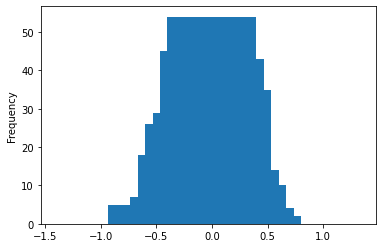

Accuracy: 0.9219
Train Epoch: 69 [0/60000 (0%)]	Loss: 0.350664
Train Epoch: 69 [5760/60000 (10%)]	Loss: 0.157967
Train Epoch: 69 [11520/60000 (19%)]	Loss: 0.295855
Train Epoch: 69 [17280/60000 (29%)]	Loss: 0.240151
Train Epoch: 69 [23040/60000 (38%)]	Loss: 0.342811
Train Epoch: 69 [28800/60000 (48%)]	Loss: 0.215752
Train Epoch: 69 [34560/60000 (58%)]	Loss: 0.150881
Train Epoch: 69 [40320/60000 (67%)]	Loss: 0.555661
Train Epoch: 69 [46080/60000 (77%)]	Loss: 0.185238
Train Epoch: 69 [51840/60000 (86%)]	Loss: 0.333449
Train Epoch: 69 [57600/60000 (96%)]	Loss: 0.280065

Test set: Average loss: 0.0018, Accuracy: 9273/10000 (93%)



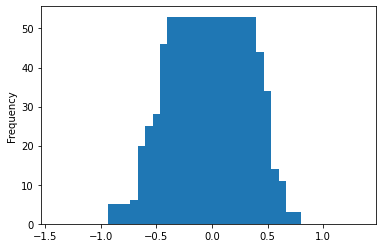

Accuracy: 0.9273
Train Epoch: 70 [0/60000 (0%)]	Loss: 0.123182
Train Epoch: 70 [5760/60000 (10%)]	Loss: 0.303059
Train Epoch: 70 [11520/60000 (19%)]	Loss: 0.141309
Train Epoch: 70 [17280/60000 (29%)]	Loss: 0.342397
Train Epoch: 70 [23040/60000 (38%)]	Loss: 0.387243
Train Epoch: 70 [28800/60000 (48%)]	Loss: 0.162361
Train Epoch: 70 [34560/60000 (58%)]	Loss: 0.264498
Train Epoch: 70 [40320/60000 (67%)]	Loss: 0.163254
Train Epoch: 70 [46080/60000 (77%)]	Loss: 0.309950
Train Epoch: 70 [51840/60000 (86%)]	Loss: 0.183975
Train Epoch: 70 [57600/60000 (96%)]	Loss: 0.195734

Test set: Average loss: 0.0019, Accuracy: 9282/10000 (93%)



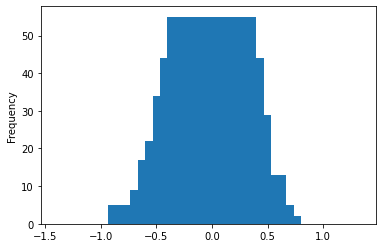

Accuracy: 0.9282
Train Epoch: 71 [0/60000 (0%)]	Loss: 0.236956
Train Epoch: 71 [5760/60000 (10%)]	Loss: 0.117684
Train Epoch: 71 [11520/60000 (19%)]	Loss: 0.216238
Train Epoch: 71 [17280/60000 (29%)]	Loss: 0.164199
Train Epoch: 71 [23040/60000 (38%)]	Loss: 0.387086
Train Epoch: 71 [28800/60000 (48%)]	Loss: 0.381515
Train Epoch: 71 [34560/60000 (58%)]	Loss: 0.363912
Train Epoch: 71 [40320/60000 (67%)]	Loss: 0.268218
Train Epoch: 71 [46080/60000 (77%)]	Loss: 0.194377
Train Epoch: 71 [51840/60000 (86%)]	Loss: 0.381397
Train Epoch: 71 [57600/60000 (96%)]	Loss: 0.340548

Test set: Average loss: 0.0017, Accuracy: 9339/10000 (93%)



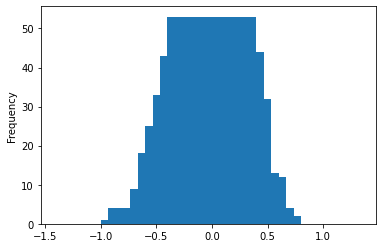

Accuracy: 0.9339
Train Epoch: 72 [0/60000 (0%)]	Loss: 0.121705
Train Epoch: 72 [5760/60000 (10%)]	Loss: 0.305407
Train Epoch: 72 [11520/60000 (19%)]	Loss: 0.169947
Train Epoch: 72 [17280/60000 (29%)]	Loss: 0.311354
Train Epoch: 72 [23040/60000 (38%)]	Loss: 0.220520
Train Epoch: 72 [28800/60000 (48%)]	Loss: 0.267968
Train Epoch: 72 [34560/60000 (58%)]	Loss: 0.309705
Train Epoch: 72 [40320/60000 (67%)]	Loss: 0.261994
Train Epoch: 72 [46080/60000 (77%)]	Loss: 0.291460
Train Epoch: 72 [51840/60000 (86%)]	Loss: 0.241721
Train Epoch: 72 [57600/60000 (96%)]	Loss: 0.180701

Test set: Average loss: 0.0019, Accuracy: 9292/10000 (93%)



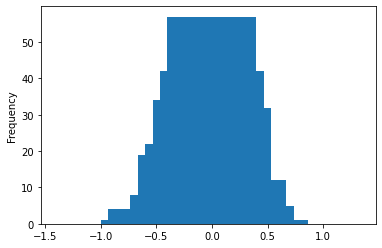

Accuracy: 0.9292
Train Epoch: 73 [0/60000 (0%)]	Loss: 0.252495
Train Epoch: 73 [5760/60000 (10%)]	Loss: 0.306449
Train Epoch: 73 [11520/60000 (19%)]	Loss: 0.097694
Train Epoch: 73 [17280/60000 (29%)]	Loss: 0.237614
Train Epoch: 73 [23040/60000 (38%)]	Loss: 0.256664
Train Epoch: 73 [28800/60000 (48%)]	Loss: 0.317421
Train Epoch: 73 [34560/60000 (58%)]	Loss: 0.210210
Train Epoch: 73 [40320/60000 (67%)]	Loss: 0.219998
Train Epoch: 73 [46080/60000 (77%)]	Loss: 0.230925
Train Epoch: 73 [51840/60000 (86%)]	Loss: 0.346869
Train Epoch: 73 [57600/60000 (96%)]	Loss: 0.243781

Test set: Average loss: 0.0017, Accuracy: 9356/10000 (94%)



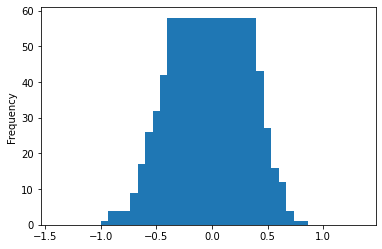

Accuracy: 0.9356
Train Epoch: 74 [0/60000 (0%)]	Loss: 0.191165
Train Epoch: 74 [5760/60000 (10%)]	Loss: 0.499165
Train Epoch: 74 [11520/60000 (19%)]	Loss: 0.182810
Train Epoch: 74 [17280/60000 (29%)]	Loss: 0.149092
Train Epoch: 74 [23040/60000 (38%)]	Loss: 0.250493
Train Epoch: 74 [28800/60000 (48%)]	Loss: 0.420637
Train Epoch: 74 [34560/60000 (58%)]	Loss: 0.299018
Train Epoch: 74 [40320/60000 (67%)]	Loss: 0.198805
Train Epoch: 74 [46080/60000 (77%)]	Loss: 0.184694
Train Epoch: 74 [51840/60000 (86%)]	Loss: 0.188861
Train Epoch: 74 [57600/60000 (96%)]	Loss: 0.264565

Test set: Average loss: 0.0017, Accuracy: 9334/10000 (93%)



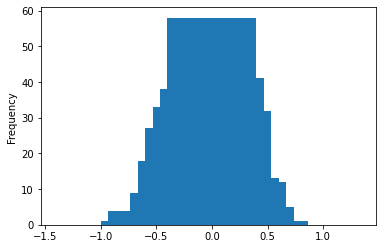

Accuracy: 0.9334
Train Epoch: 75 [0/60000 (0%)]	Loss: 0.279154
Train Epoch: 75 [5760/60000 (10%)]	Loss: 0.215493
Train Epoch: 75 [11520/60000 (19%)]	Loss: 0.449718
Train Epoch: 75 [17280/60000 (29%)]	Loss: 0.108062
Train Epoch: 75 [23040/60000 (38%)]	Loss: 0.139031
Train Epoch: 75 [28800/60000 (48%)]	Loss: 0.377736
Train Epoch: 75 [34560/60000 (58%)]	Loss: 0.211285
Train Epoch: 75 [40320/60000 (67%)]	Loss: 0.223835
Train Epoch: 75 [46080/60000 (77%)]	Loss: 0.269404
Train Epoch: 75 [51840/60000 (86%)]	Loss: 0.273041
Train Epoch: 75 [57600/60000 (96%)]	Loss: 0.334828

Test set: Average loss: 0.0019, Accuracy: 9264/10000 (93%)



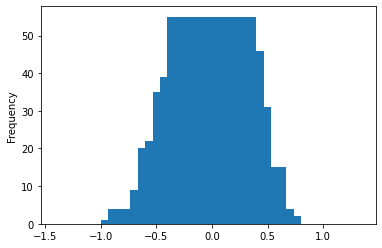

Accuracy: 0.9264
Train Epoch: 76 [0/60000 (0%)]	Loss: 0.320619
Train Epoch: 76 [5760/60000 (10%)]	Loss: 0.162887
Train Epoch: 76 [11520/60000 (19%)]	Loss: 0.230146
Train Epoch: 76 [17280/60000 (29%)]	Loss: 0.273794
Train Epoch: 76 [23040/60000 (38%)]	Loss: 0.172046
Train Epoch: 76 [28800/60000 (48%)]	Loss: 0.405721
Train Epoch: 76 [34560/60000 (58%)]	Loss: 0.373043
Train Epoch: 76 [40320/60000 (67%)]	Loss: 0.194492
Train Epoch: 76 [46080/60000 (77%)]	Loss: 0.170618
Train Epoch: 76 [51840/60000 (86%)]	Loss: 0.252033
Train Epoch: 76 [57600/60000 (96%)]	Loss: 0.304803

Test set: Average loss: 0.0018, Accuracy: 9322/10000 (93%)



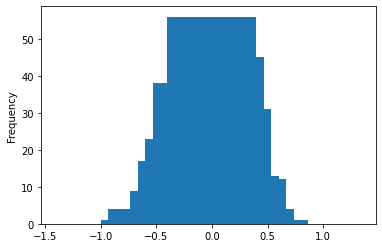

Accuracy: 0.9322
Train Epoch: 77 [0/60000 (0%)]	Loss: 0.124062
Train Epoch: 77 [5760/60000 (10%)]	Loss: 0.262053
Train Epoch: 77 [11520/60000 (19%)]	Loss: 0.274370
Train Epoch: 77 [17280/60000 (29%)]	Loss: 0.264713
Train Epoch: 77 [23040/60000 (38%)]	Loss: 0.157464
Train Epoch: 77 [28800/60000 (48%)]	Loss: 0.254986
Train Epoch: 77 [34560/60000 (58%)]	Loss: 0.200609
Train Epoch: 77 [40320/60000 (67%)]	Loss: 0.263759
Train Epoch: 77 [46080/60000 (77%)]	Loss: 0.119661
Train Epoch: 77 [51840/60000 (86%)]	Loss: 0.207787
Train Epoch: 77 [57600/60000 (96%)]	Loss: 0.174641

Test set: Average loss: 0.0017, Accuracy: 9365/10000 (94%)



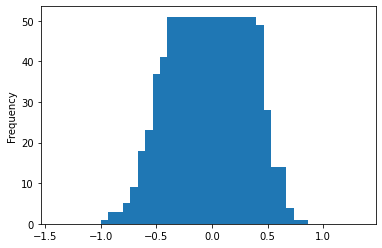

Accuracy: 0.9365
Train Epoch: 78 [0/60000 (0%)]	Loss: 0.104332
Train Epoch: 78 [5760/60000 (10%)]	Loss: 0.206913
Train Epoch: 78 [11520/60000 (19%)]	Loss: 0.173207
Train Epoch: 78 [17280/60000 (29%)]	Loss: 0.270867
Train Epoch: 78 [23040/60000 (38%)]	Loss: 0.246003
Train Epoch: 78 [28800/60000 (48%)]	Loss: 0.135362
Train Epoch: 78 [34560/60000 (58%)]	Loss: 0.330757
Train Epoch: 78 [40320/60000 (67%)]	Loss: 0.303941
Train Epoch: 78 [46080/60000 (77%)]	Loss: 0.233608
Train Epoch: 78 [51840/60000 (86%)]	Loss: 0.213712
Train Epoch: 78 [57600/60000 (96%)]	Loss: 0.261651

Test set: Average loss: 0.0017, Accuracy: 9358/10000 (94%)



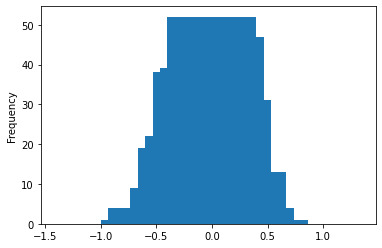

Accuracy: 0.9358
Train Epoch: 79 [0/60000 (0%)]	Loss: 0.194317
Train Epoch: 79 [5760/60000 (10%)]	Loss: 0.176904
Train Epoch: 79 [11520/60000 (19%)]	Loss: 0.159433
Train Epoch: 79 [17280/60000 (29%)]	Loss: 0.250878
Train Epoch: 79 [23040/60000 (38%)]	Loss: 0.202363
Train Epoch: 79 [28800/60000 (48%)]	Loss: 0.365762
Train Epoch: 79 [34560/60000 (58%)]	Loss: 0.327607
Train Epoch: 79 [40320/60000 (67%)]	Loss: 0.265221
Train Epoch: 79 [46080/60000 (77%)]	Loss: 0.237379
Train Epoch: 79 [51840/60000 (86%)]	Loss: 0.224271
Train Epoch: 79 [57600/60000 (96%)]	Loss: 0.154548

Test set: Average loss: 0.0019, Accuracy: 9259/10000 (93%)



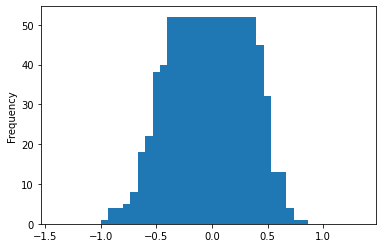

Accuracy: 0.9259
Train Epoch: 80 [0/60000 (0%)]	Loss: 0.311427
Train Epoch: 80 [5760/60000 (10%)]	Loss: 0.173355
Train Epoch: 80 [11520/60000 (19%)]	Loss: 0.273498
Train Epoch: 80 [17280/60000 (29%)]	Loss: 0.218060
Train Epoch: 80 [23040/60000 (38%)]	Loss: 0.223822
Train Epoch: 80 [28800/60000 (48%)]	Loss: 0.154666
Train Epoch: 80 [34560/60000 (58%)]	Loss: 0.177754
Train Epoch: 80 [40320/60000 (67%)]	Loss: 0.437879
Train Epoch: 80 [46080/60000 (77%)]	Loss: 0.299591
Train Epoch: 80 [51840/60000 (86%)]	Loss: 0.175466
Train Epoch: 80 [57600/60000 (96%)]	Loss: 0.129903

Test set: Average loss: 0.0018, Accuracy: 9325/10000 (93%)



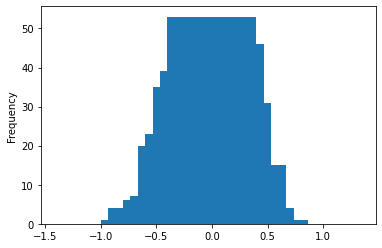

Accuracy: 0.9325
Train Epoch: 81 [0/60000 (0%)]	Loss: 0.167187
Train Epoch: 81 [5760/60000 (10%)]	Loss: 0.196738
Train Epoch: 81 [11520/60000 (19%)]	Loss: 0.224118
Train Epoch: 81 [17280/60000 (29%)]	Loss: 0.334326
Train Epoch: 81 [23040/60000 (38%)]	Loss: 0.137787
Train Epoch: 81 [28800/60000 (48%)]	Loss: 0.257615
Train Epoch: 81 [34560/60000 (58%)]	Loss: 0.289933
Train Epoch: 81 [40320/60000 (67%)]	Loss: 0.267603
Train Epoch: 81 [46080/60000 (77%)]	Loss: 0.257567
Train Epoch: 81 [51840/60000 (86%)]	Loss: 0.223480
Train Epoch: 81 [57600/60000 (96%)]	Loss: 0.187731

Test set: Average loss: 0.0017, Accuracy: 9349/10000 (93%)



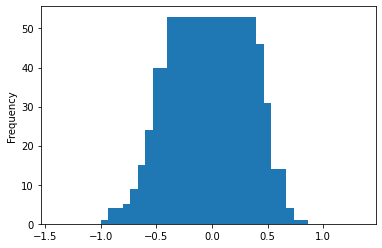

Accuracy: 0.9349
Train Epoch: 82 [0/60000 (0%)]	Loss: 0.182345
Train Epoch: 82 [5760/60000 (10%)]	Loss: 0.462372
Train Epoch: 82 [11520/60000 (19%)]	Loss: 0.180081
Train Epoch: 82 [17280/60000 (29%)]	Loss: 0.165261
Train Epoch: 82 [23040/60000 (38%)]	Loss: 0.193808
Train Epoch: 82 [28800/60000 (48%)]	Loss: 0.336658
Train Epoch: 82 [34560/60000 (58%)]	Loss: 0.292264
Train Epoch: 82 [40320/60000 (67%)]	Loss: 0.143670
Train Epoch: 82 [46080/60000 (77%)]	Loss: 0.278247
Train Epoch: 82 [51840/60000 (86%)]	Loss: 0.174025
Train Epoch: 82 [57600/60000 (96%)]	Loss: 0.232896

Test set: Average loss: 0.0020, Accuracy: 9231/10000 (92%)



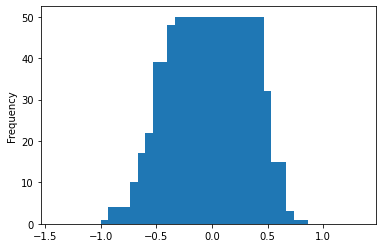

Accuracy: 0.9231
Train Epoch: 83 [0/60000 (0%)]	Loss: 0.212444
Train Epoch: 83 [5760/60000 (10%)]	Loss: 0.289820
Train Epoch: 83 [11520/60000 (19%)]	Loss: 0.175357
Train Epoch: 83 [17280/60000 (29%)]	Loss: 0.256386
Train Epoch: 83 [23040/60000 (38%)]	Loss: 0.188708
Train Epoch: 83 [28800/60000 (48%)]	Loss: 0.215606
Train Epoch: 83 [34560/60000 (58%)]	Loss: 0.129847
Train Epoch: 83 [40320/60000 (67%)]	Loss: 0.317105
Train Epoch: 83 [46080/60000 (77%)]	Loss: 0.250757
Train Epoch: 83 [51840/60000 (86%)]	Loss: 0.260818
Train Epoch: 83 [57600/60000 (96%)]	Loss: 0.354125

Test set: Average loss: 0.0017, Accuracy: 9319/10000 (93%)



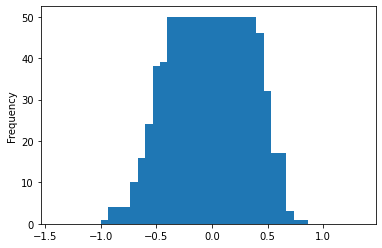

Accuracy: 0.9319
Train Epoch: 84 [0/60000 (0%)]	Loss: 0.194029
Train Epoch: 84 [5760/60000 (10%)]	Loss: 0.191062
Train Epoch: 84 [11520/60000 (19%)]	Loss: 0.275663
Train Epoch: 84 [17280/60000 (29%)]	Loss: 0.233083
Train Epoch: 84 [23040/60000 (38%)]	Loss: 0.130133
Train Epoch: 84 [28800/60000 (48%)]	Loss: 0.391295
Train Epoch: 84 [34560/60000 (58%)]	Loss: 0.234046
Train Epoch: 84 [40320/60000 (67%)]	Loss: 0.375487
Train Epoch: 84 [46080/60000 (77%)]	Loss: 0.276037
Train Epoch: 84 [51840/60000 (86%)]	Loss: 0.157403
Train Epoch: 84 [57600/60000 (96%)]	Loss: 0.142144

Test set: Average loss: 0.0017, Accuracy: 9322/10000 (93%)



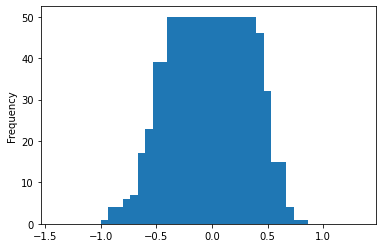

Accuracy: 0.9322
Train Epoch: 85 [0/60000 (0%)]	Loss: 0.158390
Train Epoch: 85 [5760/60000 (10%)]	Loss: 0.289749
Train Epoch: 85 [11520/60000 (19%)]	Loss: 0.215248
Train Epoch: 85 [17280/60000 (29%)]	Loss: 0.225195
Train Epoch: 85 [23040/60000 (38%)]	Loss: 0.196672
Train Epoch: 85 [28800/60000 (48%)]	Loss: 0.212402
Train Epoch: 85 [34560/60000 (58%)]	Loss: 0.282604
Train Epoch: 85 [40320/60000 (67%)]	Loss: 0.109022
Train Epoch: 85 [46080/60000 (77%)]	Loss: 0.169422
Train Epoch: 85 [51840/60000 (86%)]	Loss: 0.184822
Train Epoch: 85 [57600/60000 (96%)]	Loss: 0.105547

Test set: Average loss: 0.0018, Accuracy: 9251/10000 (93%)



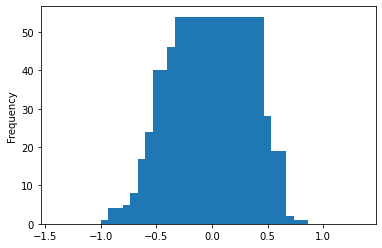

Accuracy: 0.9251
Train Epoch: 86 [0/60000 (0%)]	Loss: 0.303280
Train Epoch: 86 [5760/60000 (10%)]	Loss: 0.221844
Train Epoch: 86 [11520/60000 (19%)]	Loss: 0.208876
Train Epoch: 86 [17280/60000 (29%)]	Loss: 0.226738
Train Epoch: 86 [23040/60000 (38%)]	Loss: 0.294413
Train Epoch: 86 [28800/60000 (48%)]	Loss: 0.118534
Train Epoch: 86 [34560/60000 (58%)]	Loss: 0.333223
Train Epoch: 86 [40320/60000 (67%)]	Loss: 0.239663
Train Epoch: 86 [46080/60000 (77%)]	Loss: 0.213911
Train Epoch: 86 [51840/60000 (86%)]	Loss: 0.197392
Train Epoch: 86 [57600/60000 (96%)]	Loss: 0.174828

Test set: Average loss: 0.0018, Accuracy: 9305/10000 (93%)



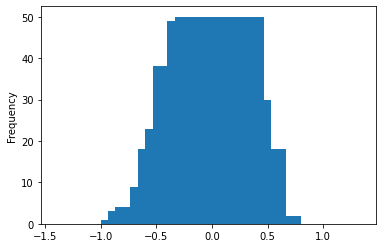

Accuracy: 0.9305
Train Epoch: 87 [0/60000 (0%)]	Loss: 0.277874
Train Epoch: 87 [5760/60000 (10%)]	Loss: 0.293798
Train Epoch: 87 [11520/60000 (19%)]	Loss: 0.331697
Train Epoch: 87 [17280/60000 (29%)]	Loss: 0.301468
Train Epoch: 87 [23040/60000 (38%)]	Loss: 0.209398
Train Epoch: 87 [28800/60000 (48%)]	Loss: 0.213250
Train Epoch: 87 [34560/60000 (58%)]	Loss: 0.183968
Train Epoch: 87 [40320/60000 (67%)]	Loss: 0.245110
Train Epoch: 87 [46080/60000 (77%)]	Loss: 0.251462
Train Epoch: 87 [51840/60000 (86%)]	Loss: 0.213669
Train Epoch: 87 [57600/60000 (96%)]	Loss: 0.208542

Test set: Average loss: 0.0016, Accuracy: 9358/10000 (94%)



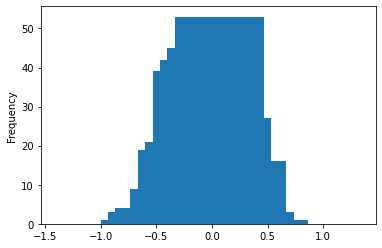

Accuracy: 0.9358
Train Epoch: 88 [0/60000 (0%)]	Loss: 0.167369
Train Epoch: 88 [5760/60000 (10%)]	Loss: 0.282365
Train Epoch: 88 [11520/60000 (19%)]	Loss: 0.228584
Train Epoch: 88 [17280/60000 (29%)]	Loss: 0.289502
Train Epoch: 88 [23040/60000 (38%)]	Loss: 0.273716
Train Epoch: 88 [28800/60000 (48%)]	Loss: 0.203709
Train Epoch: 88 [34560/60000 (58%)]	Loss: 0.331643
Train Epoch: 88 [40320/60000 (67%)]	Loss: 0.154083
Train Epoch: 88 [46080/60000 (77%)]	Loss: 0.297086
Train Epoch: 88 [51840/60000 (86%)]	Loss: 0.258212
Train Epoch: 88 [57600/60000 (96%)]	Loss: 0.122125

Test set: Average loss: 0.0017, Accuracy: 9339/10000 (93%)



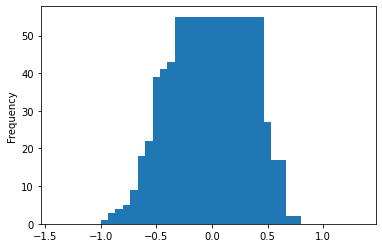

Accuracy: 0.9339
Train Epoch: 89 [0/60000 (0%)]	Loss: 0.230272
Train Epoch: 89 [5760/60000 (10%)]	Loss: 0.173844
Train Epoch: 89 [11520/60000 (19%)]	Loss: 0.301710
Train Epoch: 89 [17280/60000 (29%)]	Loss: 0.150215
Train Epoch: 89 [23040/60000 (38%)]	Loss: 0.297922
Train Epoch: 89 [28800/60000 (48%)]	Loss: 0.171812
Train Epoch: 89 [34560/60000 (58%)]	Loss: 0.314018
Train Epoch: 89 [40320/60000 (67%)]	Loss: 0.118042
Train Epoch: 89 [46080/60000 (77%)]	Loss: 0.111265
Train Epoch: 89 [51840/60000 (86%)]	Loss: 0.280008
Train Epoch: 89 [57600/60000 (96%)]	Loss: 0.177191

Test set: Average loss: 0.0017, Accuracy: 9315/10000 (93%)



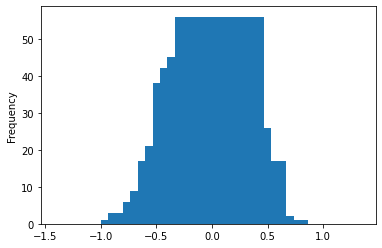

Accuracy: 0.9315
Train Epoch: 90 [0/60000 (0%)]	Loss: 0.164272
Train Epoch: 90 [5760/60000 (10%)]	Loss: 0.377420
Train Epoch: 90 [11520/60000 (19%)]	Loss: 0.286142
Train Epoch: 90 [17280/60000 (29%)]	Loss: 0.198827
Train Epoch: 90 [23040/60000 (38%)]	Loss: 0.233714
Train Epoch: 90 [28800/60000 (48%)]	Loss: 0.137266
Train Epoch: 90 [34560/60000 (58%)]	Loss: 0.209057
Train Epoch: 90 [40320/60000 (67%)]	Loss: 0.119866
Train Epoch: 90 [46080/60000 (77%)]	Loss: 0.389993
Train Epoch: 90 [51840/60000 (86%)]	Loss: 0.170369
Train Epoch: 90 [57600/60000 (96%)]	Loss: 0.248765

Test set: Average loss: 0.0018, Accuracy: 9288/10000 (93%)



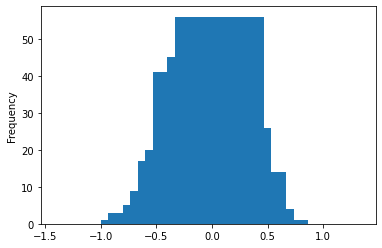

Accuracy: 0.9288
Train Epoch: 91 [0/60000 (0%)]	Loss: 0.229352
Train Epoch: 91 [5760/60000 (10%)]	Loss: 0.228918
Train Epoch: 91 [11520/60000 (19%)]	Loss: 0.186554
Train Epoch: 91 [17280/60000 (29%)]	Loss: 0.161129
Train Epoch: 91 [23040/60000 (38%)]	Loss: 0.344757
Train Epoch: 91 [28800/60000 (48%)]	Loss: 0.251941
Train Epoch: 91 [34560/60000 (58%)]	Loss: 0.203551
Train Epoch: 91 [40320/60000 (67%)]	Loss: 0.313097
Train Epoch: 91 [46080/60000 (77%)]	Loss: 0.288348
Train Epoch: 91 [51840/60000 (86%)]	Loss: 0.276728
Train Epoch: 91 [57600/60000 (96%)]	Loss: 0.166322

Test set: Average loss: 0.0017, Accuracy: 9321/10000 (93%)



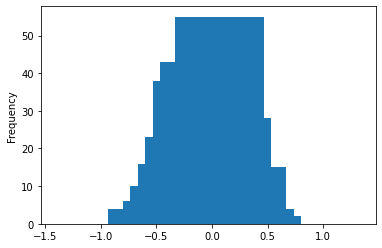

Accuracy: 0.9321
Train Epoch: 92 [0/60000 (0%)]	Loss: 0.174912
Train Epoch: 92 [5760/60000 (10%)]	Loss: 0.217995
Train Epoch: 92 [11520/60000 (19%)]	Loss: 0.226322
Train Epoch: 92 [17280/60000 (29%)]	Loss: 0.316711
Train Epoch: 92 [23040/60000 (38%)]	Loss: 0.138790
Train Epoch: 92 [28800/60000 (48%)]	Loss: 0.266011
Train Epoch: 92 [34560/60000 (58%)]	Loss: 0.200908
Train Epoch: 92 [40320/60000 (67%)]	Loss: 0.216621
Train Epoch: 92 [46080/60000 (77%)]	Loss: 0.376254
Train Epoch: 92 [51840/60000 (86%)]	Loss: 0.244275
Train Epoch: 92 [57600/60000 (96%)]	Loss: 0.230417

Test set: Average loss: 0.0016, Accuracy: 9353/10000 (94%)



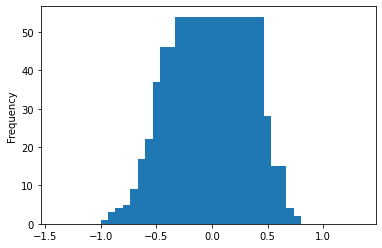

Accuracy: 0.9353
Train Epoch: 93 [0/60000 (0%)]	Loss: 0.136840
Train Epoch: 93 [5760/60000 (10%)]	Loss: 0.283079
Train Epoch: 93 [11520/60000 (19%)]	Loss: 0.195763
Train Epoch: 93 [17280/60000 (29%)]	Loss: 0.169045
Train Epoch: 93 [23040/60000 (38%)]	Loss: 0.249257
Train Epoch: 93 [28800/60000 (48%)]	Loss: 0.257977
Train Epoch: 93 [34560/60000 (58%)]	Loss: 0.120656
Train Epoch: 93 [40320/60000 (67%)]	Loss: 0.235009
Train Epoch: 93 [46080/60000 (77%)]	Loss: 0.150177
Train Epoch: 93 [51840/60000 (86%)]	Loss: 0.422951
Train Epoch: 93 [57600/60000 (96%)]	Loss: 0.256562

Test set: Average loss: 0.0017, Accuracy: 9317/10000 (93%)



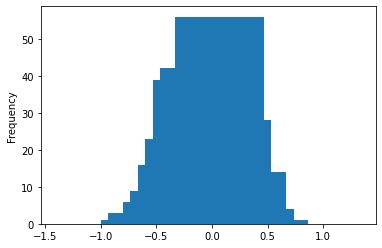

Accuracy: 0.9317
Train Epoch: 94 [0/60000 (0%)]	Loss: 0.271952
Train Epoch: 94 [5760/60000 (10%)]	Loss: 0.275154
Train Epoch: 94 [11520/60000 (19%)]	Loss: 0.345967
Train Epoch: 94 [17280/60000 (29%)]	Loss: 0.109038
Train Epoch: 94 [23040/60000 (38%)]	Loss: 0.285563
Train Epoch: 94 [28800/60000 (48%)]	Loss: 0.226432
Train Epoch: 94 [34560/60000 (58%)]	Loss: 0.190897
Train Epoch: 94 [40320/60000 (67%)]	Loss: 0.299768
Train Epoch: 94 [46080/60000 (77%)]	Loss: 0.116635
Train Epoch: 94 [51840/60000 (86%)]	Loss: 0.324958
Train Epoch: 94 [57600/60000 (96%)]	Loss: 0.267527

Test set: Average loss: 0.0022, Accuracy: 9107/10000 (91%)



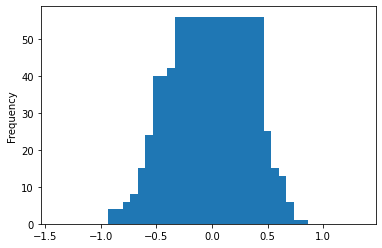

Accuracy: 0.9107
Train Epoch: 95 [0/60000 (0%)]	Loss: 0.162008
Train Epoch: 95 [5760/60000 (10%)]	Loss: 0.200682
Train Epoch: 95 [11520/60000 (19%)]	Loss: 0.175864
Train Epoch: 95 [17280/60000 (29%)]	Loss: 0.288405
Train Epoch: 95 [23040/60000 (38%)]	Loss: 0.183848
Train Epoch: 95 [28800/60000 (48%)]	Loss: 0.195309
Train Epoch: 95 [34560/60000 (58%)]	Loss: 0.204040
Train Epoch: 95 [40320/60000 (67%)]	Loss: 0.237569
Train Epoch: 95 [46080/60000 (77%)]	Loss: 0.153100
Train Epoch: 95 [51840/60000 (86%)]	Loss: 0.206616
Train Epoch: 95 [57600/60000 (96%)]	Loss: 0.297224

Test set: Average loss: 0.0016, Accuracy: 9344/10000 (93%)



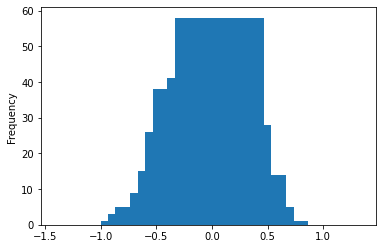

Accuracy: 0.9344
Train Epoch: 96 [0/60000 (0%)]	Loss: 0.269564
Train Epoch: 96 [5760/60000 (10%)]	Loss: 0.379892
Train Epoch: 96 [11520/60000 (19%)]	Loss: 0.153382
Train Epoch: 96 [17280/60000 (29%)]	Loss: 0.142875
Train Epoch: 96 [23040/60000 (38%)]	Loss: 0.193606
Train Epoch: 96 [28800/60000 (48%)]	Loss: 0.267532
Train Epoch: 96 [34560/60000 (58%)]	Loss: 0.168980
Train Epoch: 96 [40320/60000 (67%)]	Loss: 0.139873
Train Epoch: 96 [46080/60000 (77%)]	Loss: 0.290799
Train Epoch: 96 [51840/60000 (86%)]	Loss: 0.160263
Train Epoch: 96 [57600/60000 (96%)]	Loss: 0.257174

Test set: Average loss: 0.0017, Accuracy: 9319/10000 (93%)



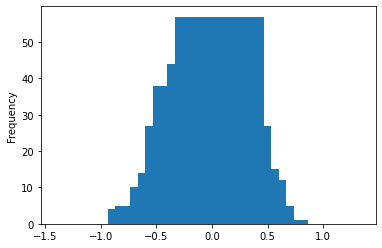

Accuracy: 0.9319
Train Epoch: 97 [0/60000 (0%)]	Loss: 0.297152
Train Epoch: 97 [5760/60000 (10%)]	Loss: 0.220738
Train Epoch: 97 [11520/60000 (19%)]	Loss: 0.157580
Train Epoch: 97 [17280/60000 (29%)]	Loss: 0.325440
Train Epoch: 97 [23040/60000 (38%)]	Loss: 0.233811
Train Epoch: 97 [28800/60000 (48%)]	Loss: 0.198436
Train Epoch: 97 [34560/60000 (58%)]	Loss: 0.142882
Train Epoch: 97 [40320/60000 (67%)]	Loss: 0.279102
Train Epoch: 97 [46080/60000 (77%)]	Loss: 0.203958
Train Epoch: 97 [51840/60000 (86%)]	Loss: 0.158281
Train Epoch: 97 [57600/60000 (96%)]	Loss: 0.339734

Test set: Average loss: 0.0017, Accuracy: 9310/10000 (93%)



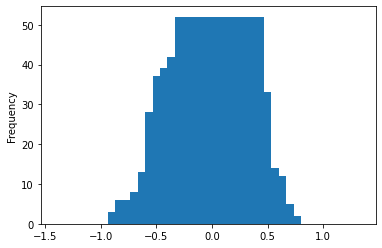

Accuracy: 0.931
Train Epoch: 98 [0/60000 (0%)]	Loss: 0.150062
Train Epoch: 98 [5760/60000 (10%)]	Loss: 0.337361
Train Epoch: 98 [11520/60000 (19%)]	Loss: 0.395677
Train Epoch: 98 [17280/60000 (29%)]	Loss: 0.142379
Train Epoch: 98 [23040/60000 (38%)]	Loss: 0.262959
Train Epoch: 98 [28800/60000 (48%)]	Loss: 0.161527
Train Epoch: 98 [34560/60000 (58%)]	Loss: 0.226412
Train Epoch: 98 [40320/60000 (67%)]	Loss: 0.209794
Train Epoch: 98 [46080/60000 (77%)]	Loss: 0.332166
Train Epoch: 98 [51840/60000 (86%)]	Loss: 0.143621
Train Epoch: 98 [57600/60000 (96%)]	Loss: 0.252668

Test set: Average loss: 0.0019, Accuracy: 9249/10000 (92%)



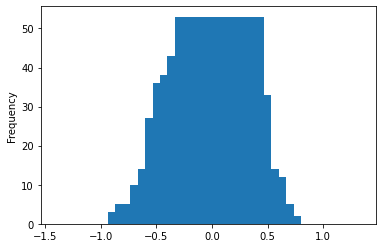

Accuracy: 0.9249
Train Epoch: 99 [0/60000 (0%)]	Loss: 0.332114
Train Epoch: 99 [5760/60000 (10%)]	Loss: 0.234768
Train Epoch: 99 [11520/60000 (19%)]	Loss: 0.090827
Train Epoch: 99 [17280/60000 (29%)]	Loss: 0.106777
Train Epoch: 99 [23040/60000 (38%)]	Loss: 0.137536
Train Epoch: 99 [28800/60000 (48%)]	Loss: 0.321434
Train Epoch: 99 [34560/60000 (58%)]	Loss: 0.223078
Train Epoch: 99 [40320/60000 (67%)]	Loss: 0.242268
Train Epoch: 99 [46080/60000 (77%)]	Loss: 0.264366
Train Epoch: 99 [51840/60000 (86%)]	Loss: 0.262970
Train Epoch: 99 [57600/60000 (96%)]	Loss: 0.156105

Test set: Average loss: 0.0016, Accuracy: 9387/10000 (94%)



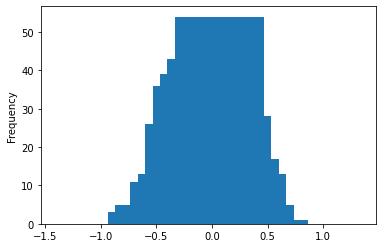

Accuracy: 0.9387


In [8]:
torch.autograd.set_detect_anomaly(True)
# train the model

# training step
def train(model, train_loader, optimizer, epoch):
    model.train()
    #train_loss_averager = make_averager()  # mantain a running average of the loss

    # TRAIN
    #tqdm_iterator = tqdm(
    #    enumerate(train_dl),
    #    total=len(train_dl),
    #    desc=f"batch [loss: None]",
    #    leave=False,)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #train_loss_averager(loss.item())

        #tqdm_iterator.set_description(
        #    f"train batch [avg loss: {train_loss_averager(None):.3f}]"
        #)
        #tqdm_iterator.refresh()

        if batch_idx % 45 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )


# testing step
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()  # sum up batch loss
            # get the index of the max probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )
    # show an histogram of the weights of the model
    start = -1
    stop = 1
    bins = 30
    for param in model.parameters():
        if param.requires_grad:
            
            hist = torch.histc(param.data, bins = bins, min = start, max = stop)
            x = np.arange(start, stop, (stop-start)/bins)
            plt.bar(x, hist.cpu(), align='center')
            plt.ylabel('Frequency')
            plt.show()

    return correct / len(test_loader.dataset)


optimizer = optim.SGD(model_intrinsic.parameters(), lr=0.01)
# train the model
for epoch in range(1, 100):
    train(model_intrinsic, train_dataloader, optimizer, epoch)
    accuracy = test(model_intrinsic, test_dataloader)
    print("Accuracy: {}".format(accuracy))
